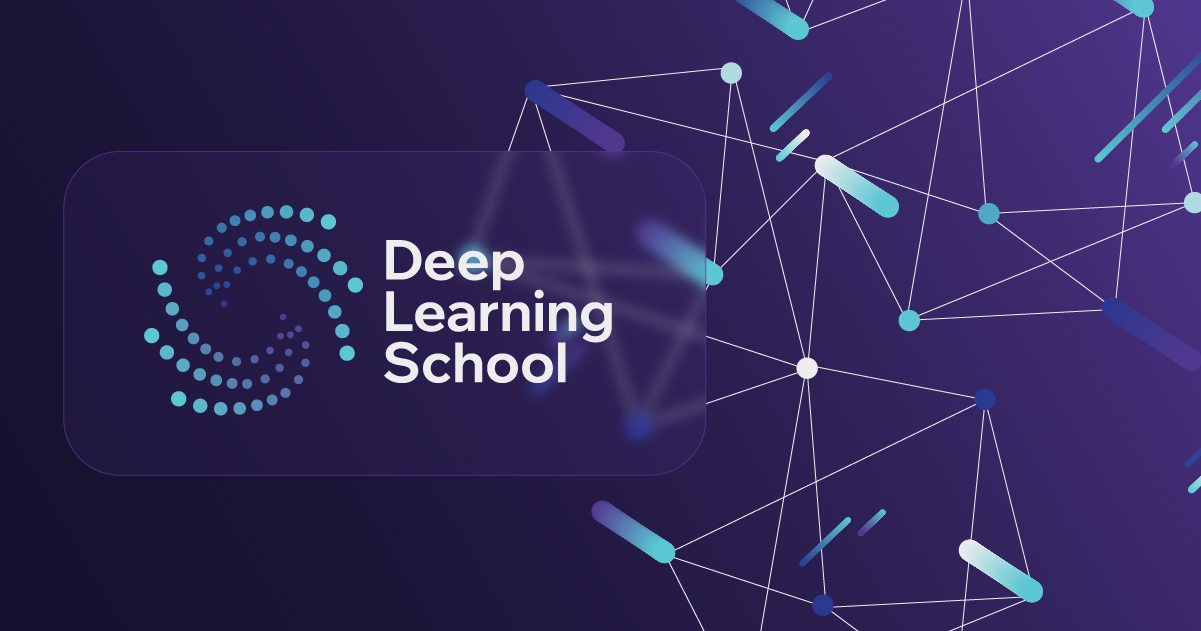


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 991 картинка, для которых вам будет необходимо предсказать класс.

!! Здесь будем работать с датасетом Симпсоны, сначала строится базовое решение на простой модели, потом идет работа с датасетом (работа с несбалансированностью классов, аугментация), а затем принципы Transfer Learning, модели AlexNet, ResNet, заморозку слоев и в целом базовые методы, изученные в ноутбуке 07_2

В данной работе есть шаги помеченные 🚫, это значит, что они не обязательны для воспроизведения, так как я использовала много разных моделей и не все они принесли хороший результат

## Шаг 1. Установка зависимостей

####Установим необходимые библиотеки и проверим доступность CUDA

In [ ]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi

Sat Jan  3 05:00:53 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import v2

import torchsummary

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


#### Проверим версии Python и библиотек
Посмотрим, какие версии установлены:

In [ ]:
!python --version
from importlib.metadata import version
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ version(b))

Python 3.12.12
torch version: 2.9.0+cu126
torchvision version: 0.24.0+cu126
tqdm version: 4.67.1
matplotlib version: 3.10.0
seaborn version: 0.13.2
Pillow version: 11.3.0


Сверим с версиями питона и библиотек, на которых работал эталонный ноутбук:

- Python 3.12.12
- torch version: 2.8.0+cu126
- torchvision version: 0.23.0+cu126
- tqdm version: 4.67.1
- matplotlib version: 3.10.0
- seaborn version: 0.13.2
- Pillow version: 11.3.0


 #### Определим константы, которые будем использовать в по ходу ноутбука

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# работаем на видеокарте
DEVICE = torch.device("cuda")

#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/content/train') #Path('./data/train/')
TEST_DIR = Path('/content/testset') #Path('./data/testset')

# параметры нормировки изображений по трем каналам перед подачей в модель
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = [224, 224]

## Шаг 2. Загрузка и обработка данных

#### Скачаем изображения по ссылке

In [ ]:
!gdown 1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1

Downloading...
From (original): https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1
From (redirected): https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1&confirm=t&uuid=7ab60e24-dc66-499a-a533-b3d0a16bfd82
To: /content/journey-springfield.zip
100% 546M/546M [00:09<00:00, 60.0MB/s]


In [ ]:
!unzip -q /content/journey-springfield.zip

Посмотрите на структуру файлов в папках train и testset.

В train лежат данные, которые мы будем использовать для обучения модели. Изображения персонажей разложены по папкам, которые названы по именам персонажей. Названия папок мы в дальнейшем будет использовать в качестве текстовых меток классов.

В testset находятся изображения, для которых вам надо будет сделать прогноз наиболее вероятного класса.


Для обращения к файлам сформируем списки имен файлов обучающей+валидационнной и тестовой выборок. Это полные имена, включающие путь к файлам.


```Path.rglob('*.jpg')``` - это метод из модуля pathlib, который рекурсивно ищет все файлы с расширением ```.jpg``` в указанной директории (TRAIN_DIR или TEST_DIR) и всех ее поддиректориях

Он возвращает итератор по объектам Path, соответствующим найденным файлам:

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_files[:6]

[PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg'),
 PosixPath('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0005.jpg')]

In [ ]:
test_files[:6]

[PosixPath('/content/testset/testset/img0.jpg'),
 PosixPath('/content/testset/testset/img1.jpg'),
 PosixPath('/content/testset/testset/img10.jpg'),
 PosixPath('/content/testset/testset/img100.jpg'),
 PosixPath('/content/testset/testset/img101.jpg'),
 PosixPath('/content/testset/testset/img102.jpg')]

Кодировать имена персонажей в числовые метки класса и обратно будем при помощи `LabelEncoder`.

Для train выборки сформируем список текстовых меток всех изображений - имя родительской директории, которая одновременно является и именем персонажа. Зададим числовые метки классов нашего энкодера при помощи метода `fit`.

Далее будем применять метод `transform` для преобразования текстовых меток в числовые, и метод `inverse_transform` для преобразования числовых меток в текстовые.


In [ ]:
label_encoder = LabelEncoder()

# содержит метки классов для каждого файла в train_val_files
train_val_labels = [path.parent.name for path in train_val_files]

label_encoder.fit(train_val_labels)

LabelEncoder()

Разделим train выборку на обучающую и валидационнную части. Для того, чтобы персонажи были пропорционально представлены в обучающей и валидационнной подвыборках, применим стратификацию по меткам класса

Стратификация будет раскидывать элементы в train_files и val_files так, чтобы пропорции каждого класса были как и в исходном train_val_labels, из-за этого выборки будут более сбалансированы

In [ ]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

####Создадим Datasets и Dataloaders

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:
https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


У нас есть набор файлов-картинок, которые требуется преобразовать в тензоры, и добавить к ним числовые метки классов. Реализуем это с помощью созданного нами класса `SimpsonsDataset`, который из списка файлов создаст необходимый нам Dataset.  

Будем действовать согласно инструкции из документации (https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files):
- наш класс будет наследовать от класса Dataset
- мы переопределим методы `__init__`, `__len__` и `__getitem__`, а также для удобства добавим несколько методов для загрузки и преобразования изображений.

Важно разобраться, что делает метод self.transform_images_to_tensors().

`Compose` объединяет последовательность следующих преобразований:
- PIL Image (Python Imaging Library) - это объект изображения, используемый библиотекой Pillow которая является стандартом де-факто для работы с изображениями в Python. Представляет изображение как матрицу пикселей с различной глубиной цвета.
`PILToTensor` конвертирует  `PIL Image` в тензор с параметрами в диапазоне $[0, 255]$ (как все пиксели в исходном изображении)
- `ToDtype` преобразует тензор в `FloatTensor` размера ($C \times H \times W$) со значениями пикселей в диапазоне $[0,1]$
- затем `Normalize` производится масштабирование:
$\text{input} = \frac{\text{input} - \text{mean}}{\text{std}} $, <br>      где константы mean и std - средние и дисперсии по каналам в датасете ImageNet
- наконец, `Resize` преобразует картинки к размеру $224 \times 224$ (в описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следует привести их к одному размеру).

Сейчас аугментация не изображений не производится, поэтому для обучающих и валидационных/тестовых изображений производится одинаковая трансформация. В дальнейшем, если вы захотите добавить аугментацию, вы можете сделать это, например, модифицировав метод `transform_images_to_tensors`. Подробнее про трансформацию изображений вы можете почитать в документации: https://docs.pytorch.org/vision/main/transforms.html




In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, label_encoder, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.label_encoder = label_encoder
        self.len_ = len(self.files)

    def __len__(self):
        return self.len_ # сейчас self.__len__() возвращает количество картинок, подаваемых на вход.
        # Если вы решите перевзвесить размеры категорий внутри класса -
        # не забудьте изменить вывод self.__len__()

    def __getitem__(self, index):
        x = self.load_image(self.files[index])
        x = self.transform_images_to_tensors(x)

        if self.mode == 'test':
            return x
        else:
            path = self.files[index]
            y = self.label_encoder.transform([path.parent.name,]).item()
            # Возвращает изображение и его числовую метку класса.
            return x, y

    # принимает путь к файлу изображения и возвращает само изображение
    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image

    # преобразует изображение в тензор
    def transform_images_to_tensors(self, image):
      if self.mode == 'train':
        # Для обучающей выборки можно добавить аугментации (сейчас закомментировано).
        transform = v2.Compose([
            v2.PILToTensor(),  # Преобразует PIL Image в тензор PyTorch (0-255).
            v2.ToDtype(torch.float32, scale=True),  # Преобразует в float32 и масштабирует до 0-1.
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),  # Нормализация изображения.
            #v2.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1), # Пример аугментации
            v2.Resize(RESCALE_SIZE),  # Изменение размера изображения до 224x224.
          ])
      else:
        transform = v2.Compose([
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            v2.Resize(RESCALE_SIZE),
          ])

      tensor_transformed = transform(image)
      return(tensor_transformed)


In [ ]:
train_dataset = SimpsonsDataset(train_files, label_encoder = label_encoder, mode='train')
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val')

In [ ]:
batch_size = 64

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
loaders = {'train':train_loader, 'val': val_loader}

#### Посмотрим на изображения персонажей

Напишем функцию для визуализации картинок. Это аналог Imshow, которая будет принимать на вход тензоры

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    # inp: Это входной параметр, представляющий собой PyTorch-тензор изображения (формат [C, H, W]),
    # значения пикселей которого были нормализованы.

    # 1. преобразуем pytorch-тензор в массив numpy
    # и меняем порядок осей с [C, H, W] на [H, W, C].
    inp = inp.numpy().transpose((1, 2, 0))

    # 2. константы среднего и стандартного отклонения для денормализации
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # 3. денормализация изображения
    inp = std * inp + mean

    # 4. обрезаем значения пикселей до диапазона [0, 1] для корректного отображения
    # 0 - черный цвет, 1 - белый, обрезаем для matplotlib
    inp = np.clip(inp, 0, 1)

    # 5. отображаем изображение на заданных осях графика
    plt_ax.imshow(inp)

    # 6. если указан заголовок, устанавливаем его
    if title is not None:
        plt_ax.set_title(title)

    # 7. отключаем сетку на графике.
    plt_ax.grid(False)

Проверим, как работает наша функция. Возьмем один батч из лоадера и подадим на вход функции первый тензор из этого батча. Заодно посмотрим, как работает кодировщик меток класса.

Числовая метка класса: 7
Текстовая метка класса: ['chief_wiggum']


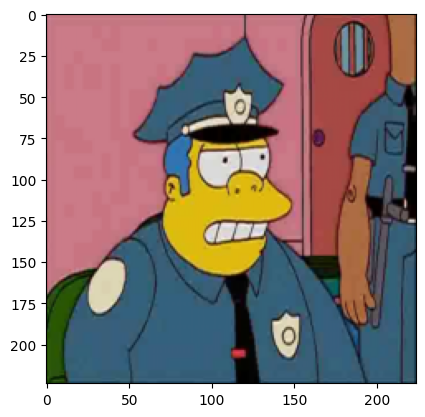

In [ ]:
image_tensor, label = next(iter(train_loader))
print(f"Числовая метка класса: {label[0]}")
print(f"Текстовая метка класса: {label_encoder.inverse_transform([label[0],])}")
imshow(image_tensor[0])


In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

In [ ]:
def show_images(n_rows, n_cols, dataset):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in ax.flatten(): # цикл повторяется (n_rows * n_cols) раз
    random_characters = int(np.random.uniform(0, len(dataset))) # берем случайное число в диапазоне [0; len(dataset))
    im_val, label = dataset[random_characters] # получаем изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()
    fig_x.set_axis_off()
  return None

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам. Очистка датасета - это один из способов повысить качество модели. Этим можно будет заняться во второй части домашнего задания.

Запустим написанную функцию.

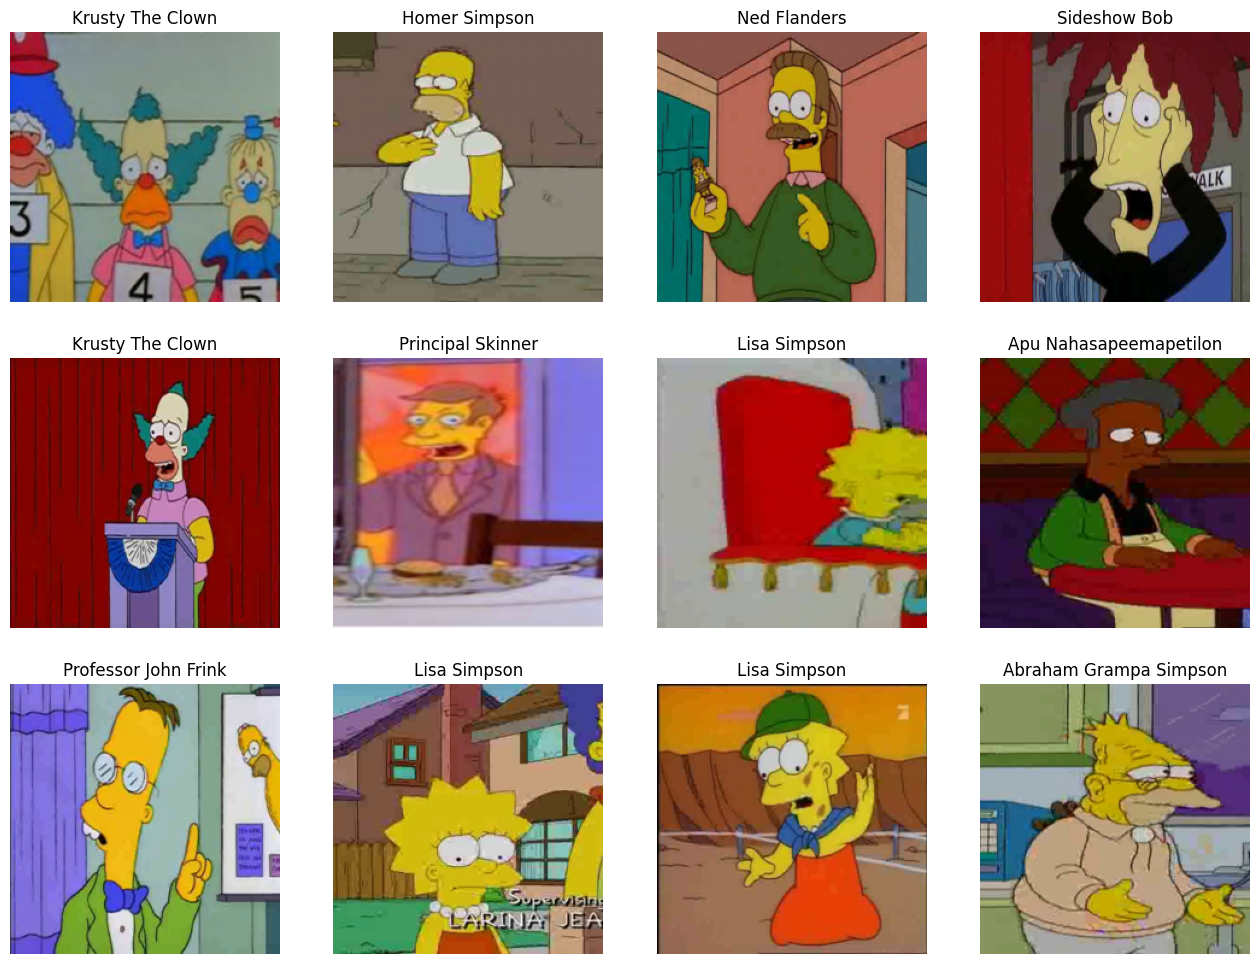

In [ ]:
show_images(n_rows = 3, n_cols = 4, dataset = val_dataset)

## Шаг 3. Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [ ]:
class SimpleCnn(nn.Module):
    """
    Очень простая сверточная нейронная сеть для классификации изображений.

    Эта сеть состоит из пяти сверточных слоев, каждый из которых
    включает в себя операцию свертки, функцию активации ReLU и операцию
    пулинга (max-pooling). На выходе используется полносвязный слой
    для классификации на заданное количество классов.

    Параметры:
    ----------
    n_classes : int
        Количество классов для классификации.

    Примечание:
    ----------
    Входные изображения должны иметь размерность (С, H, W), где
    С - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
    соответственно. Размер выходного тензора будет равен (n_classes).

    Методы:
    -------
    forward(x):
        Пропускает входные данные через сеть и возвращает логиты для
        каждого класса.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

*Описание слоев*:

1. размерность входа: $3\times 224 \times 224$
2. размерность после 1-го слоя (Conv2d + ReLU + MaxPool2d):  $8 \times 111 \times 111$
3. после 2-го слоя: $16 \times 54 \times 54$
4. после 3-го слоя: $32 \times 26 \times 26$
5. после 4-го слоя: $64 \times 12 \times 12$
6. после 5-го слоя: $96 \times 5 \times 5$
7. после полносвязного слоя (выход модели): количество классов

In [ ]:
model_simple_cnn = SimpleCnn(n_classes = len(np.unique(train_val_labels)))
model_simple_cnn.to(DEVICE)
torchsummary.summary(model_simple_cnn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,168
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 32, 52, 52]           4,640
              ReLU-8           [-1, 32, 52, 52]               0
         MaxPool2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 64, 24, 24]          18,496
             ReLU-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 96, 10, 10]          55,392
             ReLU-14           [-1, 96,

##Шаг 4. Функции для работы с моделью

#### Задание - напишите функции для работы с моделью

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Ниже приводится код для вычисления целевой метрики.

In [ ]:
from sklearn.metrics import f1_score
# пример расчета: f1 = f1_score(actual_labels, y_predicted, average='micro')

В этом задании может быть полезным сделать, чтобы функция валидации и, возможно, функция обучения на одной эпохе возвращали векторы/тензоры:
- предсказанного наиболее вероятного класса
- и фактических меток класса для каждого объекта.

Сама метрика f1, при этом, будет вычисляться не внутри функции, а вне ее, сопоставляя прогнозные и фактические значения, полученные из вывода функции.

Это поможет проанализировать, при предсказании каких классов модель ошибается чаще. Также такой подход может использоваться для обнаружения изображений, которые модель классифицирует неверно.

Для ускорения вычислений рекомендуется при работе с моделью проводить тензорные вычисления на GPU. Обращаем внимание, для этого необходимо, чтобы и данные, и модель находились на одном устройстве.

Ниже представлен код из предыдущего домашнего задания, который демонстрировал логику циклов обучения и валидации. Ниже в этот код добавлены строки комментарии, показывающие как переносить модель и данные на устройство.


```python
model.to(DEVICE)  # <- переносим модель на устройство DEVICE

for epoch in range(max_epochs):  
    # режим train
    model.train()  
    for x_batch, y_batch in train_dataloader:
        x_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        y_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        
        optimizer.zero_grad()
        outp = model(x_batch)
        loss = criterion(outp, y_batch)
        loss.backward()  
        optimizer.step()
        
        count_metrics(outp, y_batch)  # <-здесь, скорее всего, потребуется перенести данные на cpu, например с помощью метода cpu: metrics.cpu()
     
     # режим test/eval
     model.eval()  
     for x_batch, y_batch in val_dataloader:
        x_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        y_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        
        with torch.no_grad():
            outp = model(x_batch)
            count_metrics(outp, y_batch) # <-здесь, скорее всего, потребуется перенести данные на cpu       
```

Напишите функции:
- для обучения модели на одной эпохе
- для валидации модели на одной эпохе
- для реализации полного цикла обучения

За основу можно взять функции, которые вы написали в предыдущем домашнем задании.

In [ ]:
def fit_one_epoch(model, train_dataloader, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    train_dataloader - loader с выборкой для обучения модели
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`

  функция возвращает метрику accuracy по эпохе на данных из train_dataloader
  '''

  epoch_correct_predictions = 0.0
  epoch_all_predictions = 0.0
  running_loss = 0.0
  all_preds = []
  all_labels = []
  # YOUR CODE. переводим модель в режим train
  model.train()


  for X_batch, y_batch in tqdm(train_dataloader):

    # Перемещаем данные на устройство модели
    X_batch = X_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)

    # Далее далее по коду идут стандартные операции цикла обучения:
    # YOUR CODE. обнуляем градиенты модели
    optimizer.zero_grad()

    outp = model(X_batch)
    loss = loss_func(outp, y_batch)

    loss.backward() # YOUR CODE. считаем градиенты
    optimizer.step() # YOUR CODE. делаем шаг градиентного спуска

    # Рассчитаем accuracy. Для этого определим количество верных предсказаний
    # и общее количество предсказаний в каждом батче, а затем накопительным итогом посчитаем
    #  количество верных предсказаний и общее количество предсказаний в рамках эпохи
    preds = outp.argmax(-1)

    batch_size = y_batch.size(0)
    running_loss += loss.item() * batch_size
    epoch_correct_predictions += (preds == y_batch).sum().item()
    epoch_all_predictions += batch_size

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(y_batch.cpu().numpy())

  epoch_loss = running_loss / epoch_all_predictions

  return epoch_loss, all_preds, all_labels

In [ ]:
def eval_one_epoch(model, val_dataloader, loss_func):
  '''
  args:
    model - модель для обучения
    val_dataloader - loader с валидационной/тестовой выборкой
  '''

  epoch_correct_predictions = 0.0
  epoch_all_predictions = 0.0
  running_loss = 0.0
  all_preds = []
  all_labels = []

  model.eval()

  for X_batch, y_batch in tqdm(val_dataloader):

    X_batch = X_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)

    with torch.no_grad():

      outp = model(X_batch)
      loss = loss_func(outp, y_batch)

    # YOUR CODE. Определяем нииболее вероятный класс для каждого объекта в батче
    preds = outp.argmax(-1)

    # Рассчитаем accuracy
    bs = y_batch.size(0)
    running_loss += loss.item() * bs
    epoch_correct_predictions += (preds == y_batch).sum().item()
    epoch_all_predictions += y_batch.size(0)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(y_batch.cpu().numpy())

  epoch_loss = running_loss / epoch_all_predictions

  return epoch_loss, all_preds, all_labels

In [ ]:
def train_func(model, num_epochs, dataloaders, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    num_epochs - количество эпох
    dataloaders - словарь loader'ов с обучающей и валидационной выборками
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`
    logdir - директория для логирования в TensorBoard

  функция возвращает accuracy на обучающей и валидационной выборках на каждой эпохе
  '''

  history = {
      "train_loss": [], "valid_loss": [],
      "train_f1": [], "valid_f1": []
  }

  for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}")

    loss_train, train_preds, train_labels = fit_one_epoch(
        model=model,
        train_dataloader=dataloaders['train'],
        optimizer=optimizer,
        loss_func=loss_func
    )
    f1_train = f1_score(train_labels, train_preds, average='micro')
    print(f"Train | loss: {loss_train:.4f} | f1: {f1_train:.4f}")

    loss_valid, valid_preds, valid_labels = eval_one_epoch(
        model=model,
        val_dataloader=dataloaders['val'],
        loss_func=loss_func
    )
    f1_valid = f1_score(valid_labels, valid_preds, average='micro')

    print(f"Valid | loss: {loss_valid:.4f} | f1: {f1_valid:.4f}")

    history["train_loss"].append(loss_train)
    history["valid_loss"].append(loss_valid)
    history["train_f1"].append(f1_train)
    history["valid_f1"].append(f1_valid)


  return history

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["valid_loss"], label="valid")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # F1-score
    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_f1"], label="train")
    plt.plot(epochs, history["valid_f1"], label="valid")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.title("F1-score per epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

## 🚫Шаг 5. Применение модели к данным

#### Применение модели к данным

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_simple_cnn.parameters(), lr = 1e-3)

Запустите обучение сети

In [ ]:
history = train_func(model = model_simple_cnn,
           num_epochs = 10,
           dataloaders = loaders,
           optimizer = optimizer,
           loss_func = criterion)


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.0681 | f1: 0.7069


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.0897 | f1: 0.7062

Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.7455 | f1: 0.7919


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.9871 | f1: 0.7505

Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.5350 | f1: 0.8455


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.8910 | f1: 0.7774

Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.3790 | f1: 0.8901


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.9764 | f1: 0.7768

Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.2655 | f1: 0.9206


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.0225 | f1: 0.7950

Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1917 | f1: 0.9404


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.1260 | f1: 0.7938

Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1426 | f1: 0.9541


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.2476 | f1: 0.7862

Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1153 | f1: 0.9639


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.3041 | f1: 0.7948

Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0962 | f1: 0.9687


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.4723 | f1: 0.7853

Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0809 | f1: 0.9739


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.5168 | f1: 0.7864


(опционально) Постройте график динамики метрик модели по ходу обучения

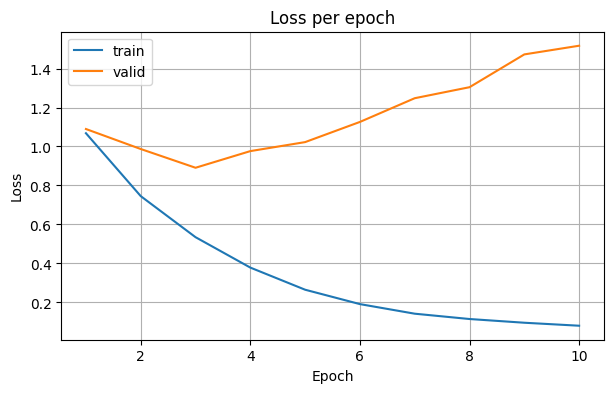

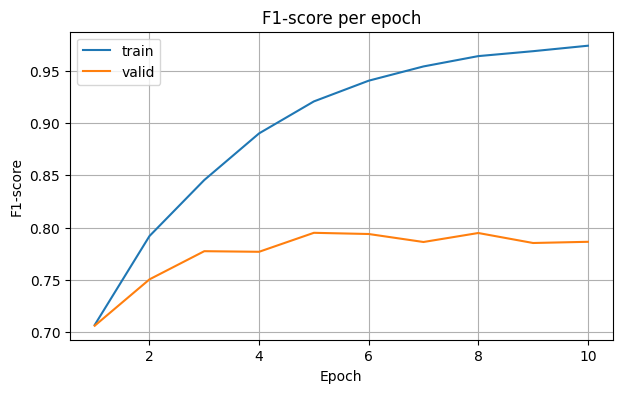

In [ ]:
plot_history(history)

Видим, что модель переобучилась, лосс на валидации ужасный, как и метрика f1

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

@torch.no_grad()
def show_images2(n_rows, n_cols, dataset, model):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in axs.flatten(): # цикл повторяется (n_rows * n_cols) раз
    random_characters = int(np.random.uniform(0, len(dataset))) # берем случайное число в диапазоне [0; len(dataset))
    im_val, label = dataset[random_characters] # выводим изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()

    # ниже представлен код для добавления на изображение подписи с вероятностью класса
    actual_text = "Actual : {}".format(img_label)


    font0 = FontProperties()
    font = font0.copy()

    # наша модель возвращает логиты, поэтому для получения вероятностей классов не забываем применить softmax:
    prob_pred = nn.functional.softmax(model(im_val.unsqueeze(0).to(DEVICE)), dim = -1).cpu().numpy()

    predicted_proba = np.max(prob_pred)*100 # берем максимальную вероятность класса
    y_pred = np.argmax(prob_pred) # берем числовую метку класса, для которого вероятность максимальна

    predicted_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([y_pred])[0].split('_')))
    predicted_text = "{}:\n {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.add_patch(patches.Rectangle((0, 190), 7*len(predicted_label), 25,color='white'))
    fig_x.text(2, 195, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
    fig_x.set_axis_off()

  return None

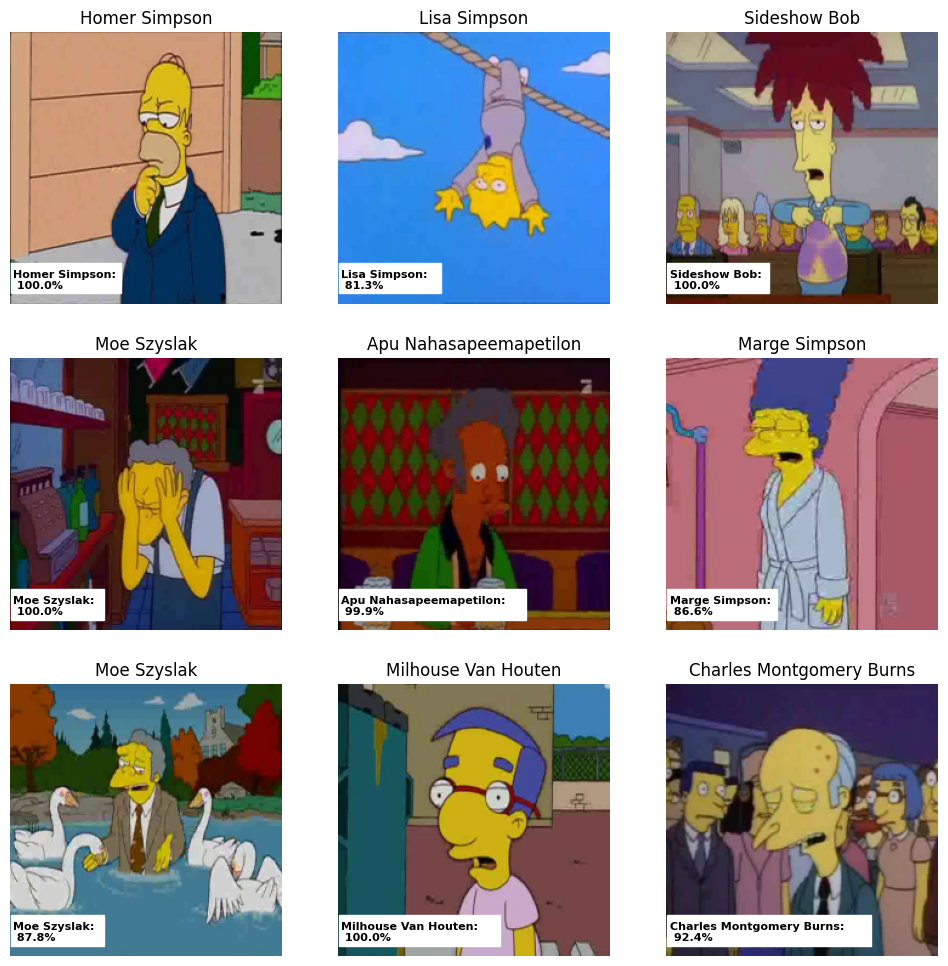

In [ ]:
show_images2(n_rows = 3, n_cols = 3, dataset = val_dataset, model = model_simple_cnn)

## 🚫Шаг 6. Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

Создадим loader для тестовых данных

In [ ]:
test_dataset = SimpsonsDataset(test_files, label_encoder = label_encoder, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

Воспользуемся функцией predict, которая возвращает предсказанные числовые метки для всех объектов в лоадере.

In [ ]:
def predict(model, loader):
    model.eval()
    all_predictions = torch.tensor([]).to(DEVICE).int()
    print("Test mode...")
    for inputs in tqdm_notebook(loader):
        inputs = inputs.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)

            predictions = outputs.argmax(-1).int()
            all_predictions = torch.cat((all_predictions, predictions), 0)
    return all_predictions.cpu()

Получем предсказание меток классов для тестовых данных:

In [ ]:
predicted_numeric_labels = predict(model_extractor, test_loader)

Test mode...


  0%|          | 0/16 [00:00<?, ?it/s]

и преобразуем их в текстовые метки:

In [ ]:
predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)

Загрузим пример файла для загрузки на Kaggle (проверьте путь, по которому у вас лежит файл sample_submission.csv и при необходимости скорректируйте путь в коде ниже):

In [ ]:
import pandas as pd
sample_submission = pd.read_csv("/content/sample_submission.csv")
sample_submission.head(10)

Id      Expected
0  img0.jpg  bart_simpson
1  img1.jpg  bart_simpson
2  img2.jpg  bart_simpson
3  img3.jpg  bart_simpson
4  img4.jpg  bart_simpson
5  img5.jpg  bart_simpson
6  img6.jpg  bart_simpson
7  img7.jpg  bart_simpson
8  img8.jpg  bart_simpson
9  img9.jpg  bart_simpson

In [ ]:
my_submission = pd.DataFrame({'Id': [path.name for path in test_files], 'Expected': predicted_text_labels})
my_submission.head(10)

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon
5  img102.jpg           kent_brockman
6  img103.jpg          edna_krabappel
7  img104.jpg            chief_wiggum
8  img105.jpg            lisa_simpson
9  img106.jpg           kent_brockman

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submission.to_csv('resnet_lr.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся score нас явно не устраивает. Надо с этим что-то сделать.

Вам предлагается творческая и исследовательская свобода в том, как вы будете улучшать score модели. Вот некоторые направления, которые вы, возможно, захотите попробовать:
1. Работа с датасетом:
* Попробуйте увеличить разнообразие обучающей выборки при помощи аугментации ([ссылка 1](https://habr.com/ru/companies/smartengines/articles/264677/), [ссылка 2](https://www.geeksforgeeks.org/python-data-augmentation/));
* Используя результаты функции eval_one_epoch, вы можете посмотреть, как метрика f1-score внутри класса связана с размером самого класса в обучающей выборке. Скорее всего, вы заметите прямую зависимость. Решением может быть увеличение размеров слабо представленных классов. Сделать это можно, вручную добавив этот функционал в SimpsonsDataset или воспользовавшись инструментом WeightedRandomSampler.

* Также вы можете изучить, какие изображения модель классифицирует неверно. Можно просто посмотреть неверно классифицированные изображения в валидационном датасете. Можно попробовать более фундаментальный подход - создать dataloader из всех изображений обучающей и валидационной выборки в SimpsonsDataset c режимом 'val', прогнать данные через обученную модель simple_cnn. Более того, можно обучить несколько моделей с разной архитектурой, и прогнать объединенный датасет через все эти модели - и выделить те изображения, в классификации которых ошиблись несколько моделей.

* Это поможет понять, как качество и чистота исходных данных влияет на результаты обучения модели. Если вы обнаружите ошибки в simpsons_dataset и решите их исправить или удалить некоторые изображения из обучающей выборки - сделайте это в ноутбуке, чтобы при проверке можно было повторить результаты работы вашего кода.  

2. Работа с архитектурой сети:
* учим дольше и изменяем (подбираем) гиперпараметры: learning rate, batch size, нормализация картинки и вот это всё;
* добавление/удаление свёрточных и полносвязных слоёв;
* А еще есть где пулинги и батч-норм!

3. Применение техник, описанных в предыдущих пунктах, позволяет добиться довольно высоких результатов. Но вы можете попробовать файнтютинг и трансферлёнинг:
* ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

4. Улучшение оптимизации:
* ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

5. Наконец, возможно, стоит подумать об ансамблях


Надеюсь, что у Вас получится!

## Шаг 7. Работа с датасетом

### Аугментация

У нас есть собственноручно написанный класс `SimpsonsDataset`, где мы обрабатываем наш датасет, как train, так и test. Соответственно там мы и можем ввести аугментацию, поэтому переопределим наш класс:

Также я столкнулась с проблемой: из-за аугментации данных, время обучения повысилось кратно, поэтому я немного изменила логику класса, те операции, которые можно было сделать на GPU, я перенесла туда. Так время на 1 эпоху на train сократилось с 3 минут до 1.5 минуты. Также `transform_images_to_tensors` в такой реализации теперь не нужно

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, label_encoder, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.label_encoder = label_encoder
        self.len_ = len(self.files)

        # Трансформации, которые всегда выполняются на CPU (PIL Image -> CPU Tensor)
        self.cpu_initial_transforms = v2.Compose([
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),  # Преобразует в float32 и масштабирует до 0-1
        ])

        # Трансформации, которые будут выполняться на GPU (если тензор уже на GPU)
        if self.mode == 'train':
            self.gpu_transforms = v2.Compose([
                v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                v2.RandomRotation(25),
                v2.RandomHorizontalFlip(),
                v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                v2.Resize(RESCALE_SIZE),
            ])
        else:
            self.gpu_transforms = v2.Compose([
                v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                v2.Resize(RESCALE_SIZE),
            ])

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        x = self.load_image(self.files[index])

        # Сначала применяем CPU-трансформации
        x = self.cpu_initial_transforms(x)

        # Затем перемещаем тензор на GPU
        x = x.to(DEVICE)

        # После этого применяем GPU-трансформации
        x = self.gpu_transforms(x)

        if self.mode == 'test':
            return x
        else:
            path = self.files[index]
            y = self.label_encoder.transform([path.parent.name,]).item()
            return x, y

    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image

    # transform_images_to_tensors больше не нужен в таком виде,
    # его логика перенесена в __getitem__ для управления устройством
    # def transform_images_to_tensors(self, image):
    #     raise NotImplementedError("This method is no longer used. Transforms are applied in __getitem__.")


In [ ]:
def train_func(model, num_epochs, dataloaders, optimizer, loss_func, label_encoder):
  '''
  args:
    model - модель для обучения
    num_epochs - количество эпох
    dataloaders - словарь loader'ов с обучающей и валидационной выборками
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`
    label_encoder - кодировщик меток для преобразования числовых меток в текстовые
  функция возвращает accuracy на обучающей и валидационной выборках на каждой эпохе
  '''

  history = {
      "train_loss": [], "valid_loss": [],
      "train_f1": [], "valid_f1": [],
      "train_f1_per_class": [],
      "valid_f1_per_class": []
  }

  for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}")

    loss_train, train_preds, train_labels = fit_one_epoch(
        model=model,
        train_dataloader=dataloaders['train'],
        optimizer=optimizer,
        loss_func=loss_func
    )
    f1_train = f1_score(train_labels, train_preds, average='micro')
    f1_train_per_class = f1_score(train_labels, train_preds, average=None)

    print(f"Train | loss: {loss_train:.4f} | f1: {f1_train:.4f}")

    loss_valid, valid_preds, valid_labels = eval_one_epoch(
        model=model,
        val_dataloader=dataloaders['val'],
        loss_func=loss_func
    )
    f1_valid = f1_score(valid_labels, valid_preds, average='micro')
    f1_valid_per_class = f1_score(valid_labels, valid_preds, average=None)

    print(f"Valid | loss: {loss_valid:.4f} | f1: {f1_valid:.4f}")

    history["train_loss"].append(loss_train)
    history["valid_loss"].append(loss_valid)
    history["train_f1"].append(f1_train)
    history["valid_f1"].append(f1_valid)
    history["train_f1_per_class"].append(f1_train_per_class)
    history["valid_f1_per_class"].append(f1_valid_per_class)


  return history

Мы также хотим посмотреть как распределяется f1_score по классам, то есть какие классы плохо предсказываются. для этого построим столбчатый график. Отредактируем plot_history:

In [ ]:
def plot_history(history, label_encoder):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["valid_loss"], label="valid")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # F1-score overall
    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_f1"], label="train")
    plt.plot(epochs, history["valid_f1"], label="valid")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score (overall)")
    plt.title("F1-score (overall) per epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # F1-score per class for the last epoch
    if history["valid_f1_per_class"]:
        last_epoch_f1_per_class = history["valid_f1_per_class"][-1]
        class_names = label_encoder.inverse_transform(np.arange(len(last_epoch_f1_per_class)))

        # Создаем Series для удобной сортировки
        f1_series = pd.Series(last_epoch_f1_per_class, index=class_names)
        f1_series_sorted = f1_series.sort_values(ascending=False)

        plt.figure(figsize=(15, 7))
        plt.bar(f1_series_sorted.index, f1_series_sorted.values, color='skyblue')
        plt.xlabel("Class")
        plt.ylabel("F1-score")
        plt.title("F1-score per Class (Last Epoch - Sorted)")
        plt.xticks(rotation=90)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

In [ ]:
train_dataset = SimpsonsDataset(train_files, label_encoder = label_encoder, mode='train')
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
loaders = {'train':train_loader, 'val': val_loader}

In [ ]:
model_simple_cnn = SimpleCnn(n_classes = len(np.unique(train_val_labels)))
model_simple_cnn.to(DEVICE)
torchsummary.summary(model_simple_cnn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,168
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 32, 52, 52]           4,640
              ReLU-8           [-1, 32, 52, 52]               0
         MaxPool2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 64, 24, 24]          18,496
             ReLU-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 96, 10, 10]          55,392
             ReLU-14           [-1, 96,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_simple_cnn.parameters(), lr = 1e-3) # Changed learning rate back to 1e-3

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
history = train_func(model = model_simple_cnn,
           num_epochs = 10,
           dataloaders = loaders,
           optimizer = optimizer,
           loss_func = criterion,
           label_encoder = label_encoder)


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 2.0210 | f1: 0.4576


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.5830 | f1: 0.5778

Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.5045 | f1: 0.5891


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.2695 | f1: 0.6530

Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.2215 | f1: 0.6699


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.0755 | f1: 0.7071

Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.0106 | f1: 0.7199


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.9812 | f1: 0.7321

Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.8647 | f1: 0.7625


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.8534 | f1: 0.7688

Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.7614 | f1: 0.7870


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.8058 | f1: 0.7835

Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.6691 | f1: 0.8112


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.7705 | f1: 0.7921

Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.6031 | f1: 0.8309


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.7299 | f1: 0.8099

Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.5535 | f1: 0.8449


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.7385 | f1: 0.8097

Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.5152 | f1: 0.8513


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.7245 | f1: 0.8120


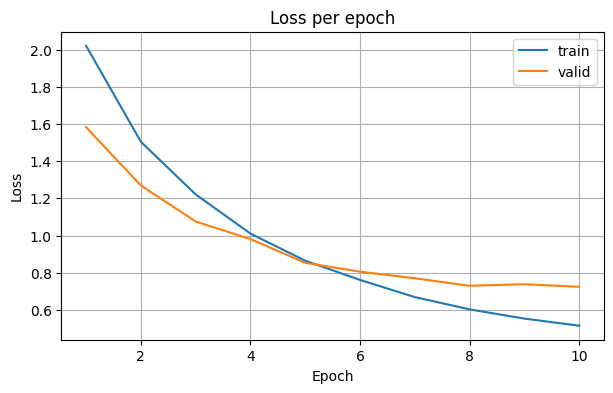

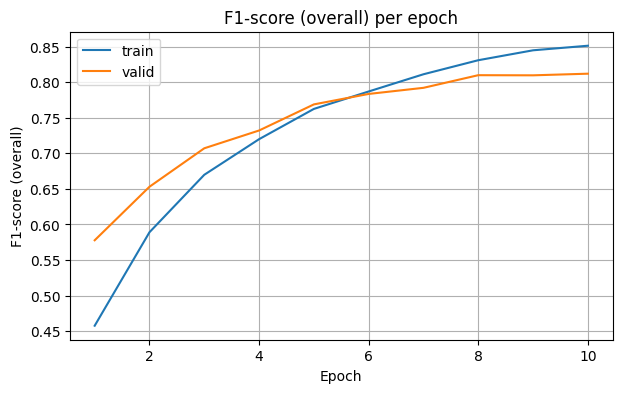

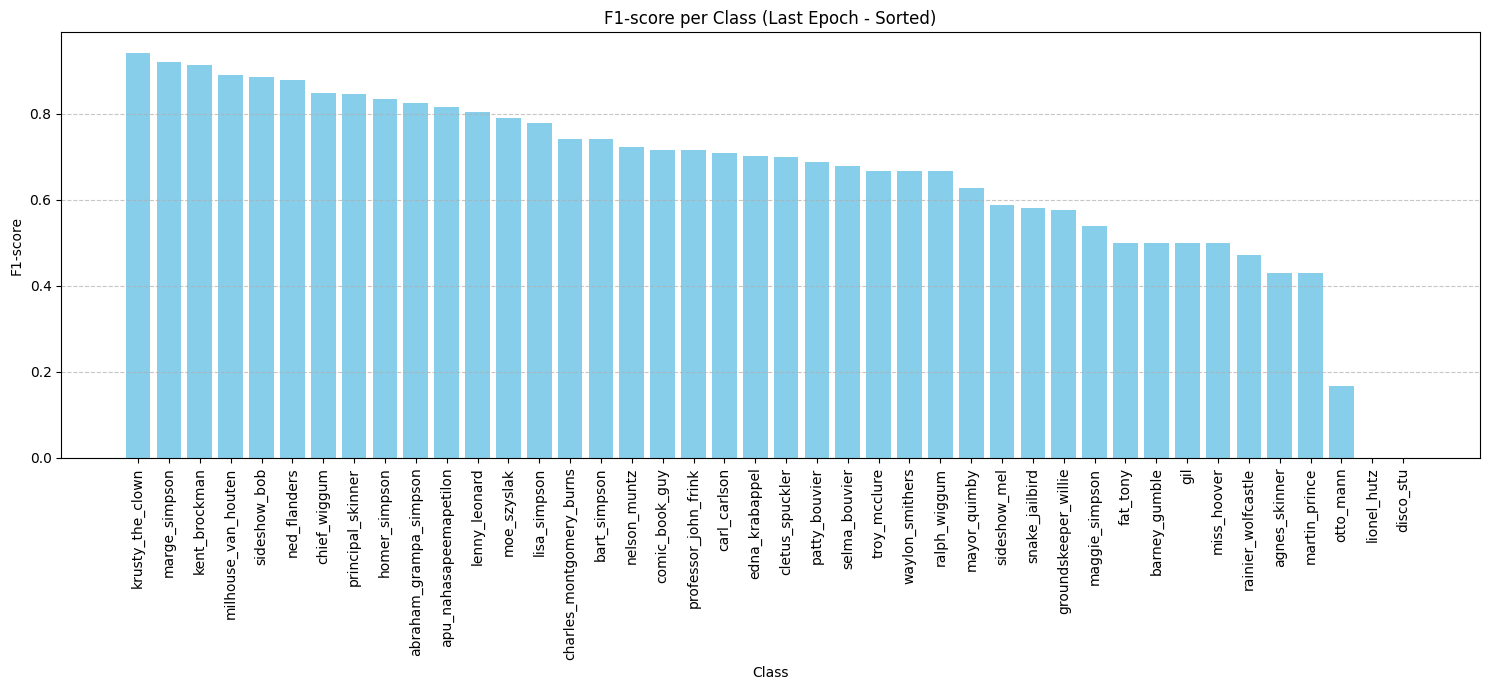

In [ ]:
plot_history(history, label_encoder)

Оставлю блок про то как сохранять модели на диск

Результат без аугментации:

Train | loss: 0.0809 | f1: 0.9739

Valid | loss: 1.5168 | f1: 0.7864

С аугментацией:

Train | loss: 0.5152 | f1: 0.8513

Valid | loss: 0.7245 | f1: 0.8120

In [ ]:
# from google.colab import drive
# import pickle

# # Mount Google Drive
# drive.mount('/content/drive')

# # Define paths for saving
# save_path_model = '/content/drive/MyDrive/Colab Notebooks/блок 7/simple_cnn_model_with_augmentation.pth'
# save_path_history = '/content/drive/MyDrive/Colab Notebooks/блок 7/training_history_with_augmentation.pkl'

# # Save the model
# torch.save(model_simple_cnn.state_dict(), save_path_model)
# print(f"Model saved to {save_path_model}")

# # Save the history
# with open(save_path_history, 'wb') as f:
#     pickle.dump(history, f)
# print(f"Training history saved to {save_path_history}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/Colab Notebooks/блок 7/simple_cnn_model_with_augmentation.pth
Training history saved to /content/drive/MyDrive/Colab Notebooks/блок 7/training_history_with_augmentation.pkl


Видим, что есть классы, которые вообще не предсказываются (disco_stu, lionel_hutz). Или делают это плохо, <= 0.5 у agnes_skinner, barney_gumble, cletus_spuckler, gil, maggie_simpson, professor_john_frink, ralph_wiggum

Посмотрим какие классы у нас слабо представлены:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Получаем все файлы из тренировочной директории
all_train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

# Извлекаем метки классов (имена персонажей) из путей к файлам
all_train_labels = [path.parent.name for path in all_train_files]

# Создаем Series из меток и подсчитываем количество каждого класса
class_distribution = pd.Series(all_train_labels).value_counts()

# display(class_distribution)

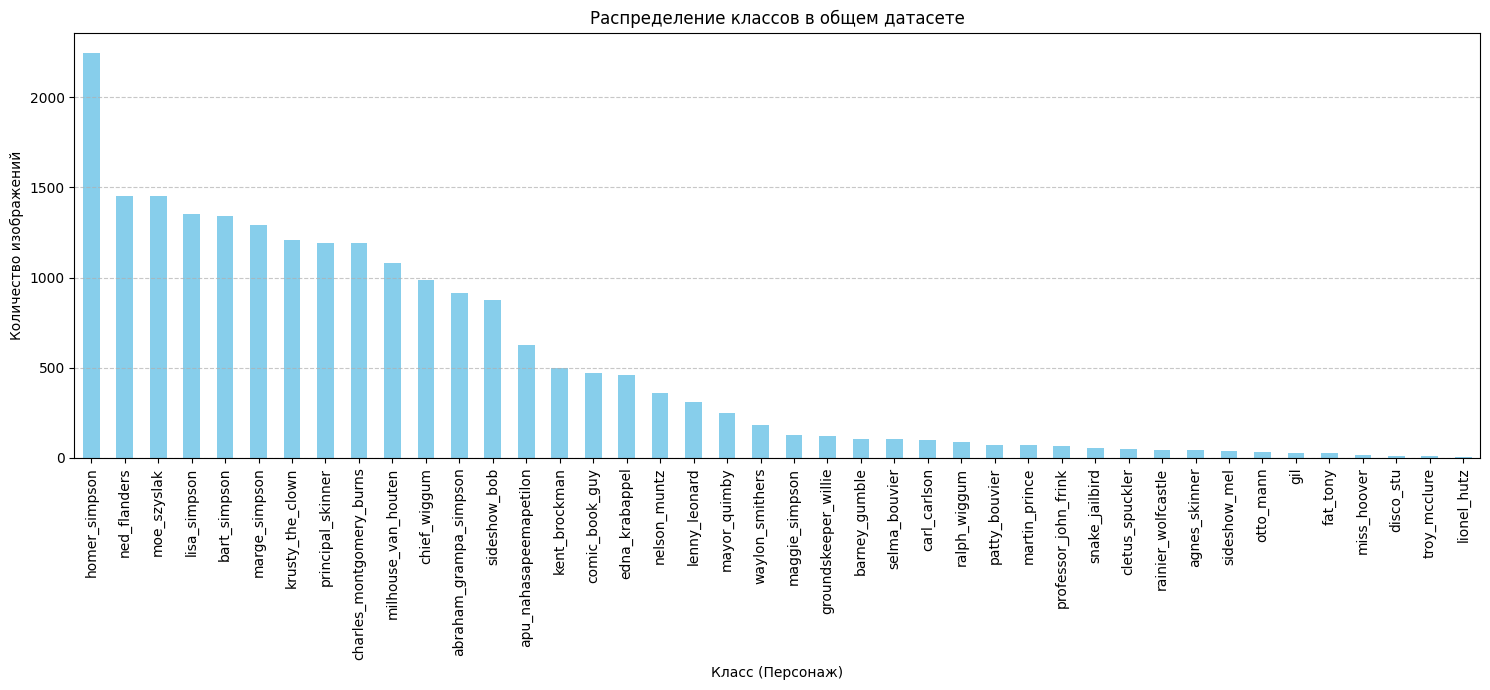

In [ ]:
# Визуализация распределения классов
plt.figure(figsize=(15, 7))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Распределение классов в общем датасете')
plt.xlabel('Класс (Персонаж)')
plt.ylabel('Количество изображений')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 🚫WeightesRandomSampler

Причем видим, что слабо представленный класс не всегда плохо фильтруется. Например на графике с f1 score на валидационном датасете kent_brockman первый, хотя данного класса всего 500 экземпляров

Давайте теперь используем `WeightedRandomSampler`и попытаемся сбалансировать классы. Для начала в тренировочном датасете определим вес для каждого класса. После чего назначим вес каждому изображению и `WeightedRandomSampler` создает вероятностную выборку с замещением

!! По итогу такая модель оказалась хуже, поэтому от нее откажемся

In [ ]:
from torch.utils.data import WeightedRandomSampler

# 1. Сначала получим все метки классов для тренировочного набора
train_labels_numeric = [train_dataset[i][1] for i in range(len(train_dataset))]

# 2. Подсчитаем количество каждого класса
class_counts = np.bincount(train_labels_numeric)

# 3. Вычислим веса для каждого класса
# Вес будет обратно пропорционален количеству изображений в классе.
# Меньше изображений -> больше вес.
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

# 4. Назначим вес каждому изображению в тренировочном наборе
# Создадим список весов, где каждый вес соответствует изображению
sample_weights = [class_weights[label] for label in train_labels_numeric]
sample_weights = torch.tensor(sample_weights)

# 5. Создадим WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True # Выборка с замещением, так как нам нужно, чтобы редкие классы могли быть выбраны несколько раз
)


In [ ]:
# 6. Обновим train_loader, чтобы использовать WeightedRandomSampler
# Для val_loader sampler не нужен, там важна репрезентативность, а не балансировка

train_loader_balanced = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler, # Передаем sampler вместо shuffle=True
    num_workers=0,
    pin_memory=False
)

# Сохраняем val_loader без изменений
val_loader_original = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

loaders_balanced = {'train': train_loader_balanced, 'val': val_loader_original}

DataLoaders updated with WeightedRandomSampler for training!


Теперь, когда `DataLoader` для тренировочной выборки настроен с `WeightedRandomSampler`, вы можете запустить обучение модели с `loaders_balanced` вместо `loaders`.


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 3.5112 | f1: 0.0960


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 3.3615 | f1: 0.0995

Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 2.7581 | f1: 0.2896


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 2.8119 | f1: 0.2482

Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 2.3620 | f1: 0.3974


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 2.6342 | f1: 0.3107

Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 2.1170 | f1: 0.4565


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 2.5236 | f1: 0.3336

Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.9234 | f1: 0.5080


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 2.4018 | f1: 0.3642

Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.7654 | f1: 0.5486


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 2.1824 | f1: 0.4259

Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.6098 | f1: 0.5842


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 2.1348 | f1: 0.4356

Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.4936 | f1: 0.6172


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 2.0398 | f1: 0.4633

Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.3869 | f1: 0.6396


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.8910 | f1: 0.5040

Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.2617 | f1: 0.6746


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.8598 | f1: 0.5136

Epoch: 11


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.1963 | f1: 0.6904


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.8231 | f1: 0.5267

Epoch: 12


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.1087 | f1: 0.7134


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.7973 | f1: 0.5329

Epoch: 13


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.0511 | f1: 0.7283


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.6880 | f1: 0.5571

Epoch: 14


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.0186 | f1: 0.7343


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.7009 | f1: 0.5627

Epoch: 15


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.9538 | f1: 0.7557


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.6117 | f1: 0.5856


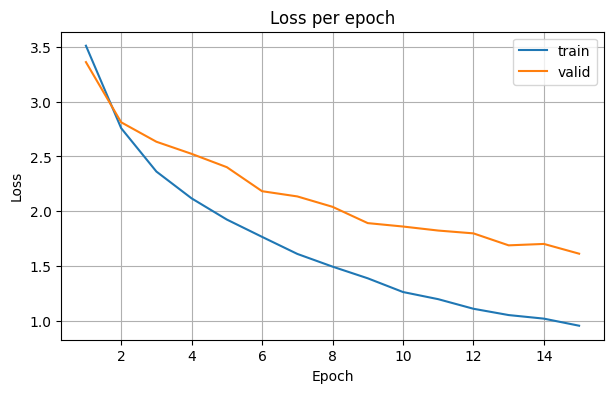

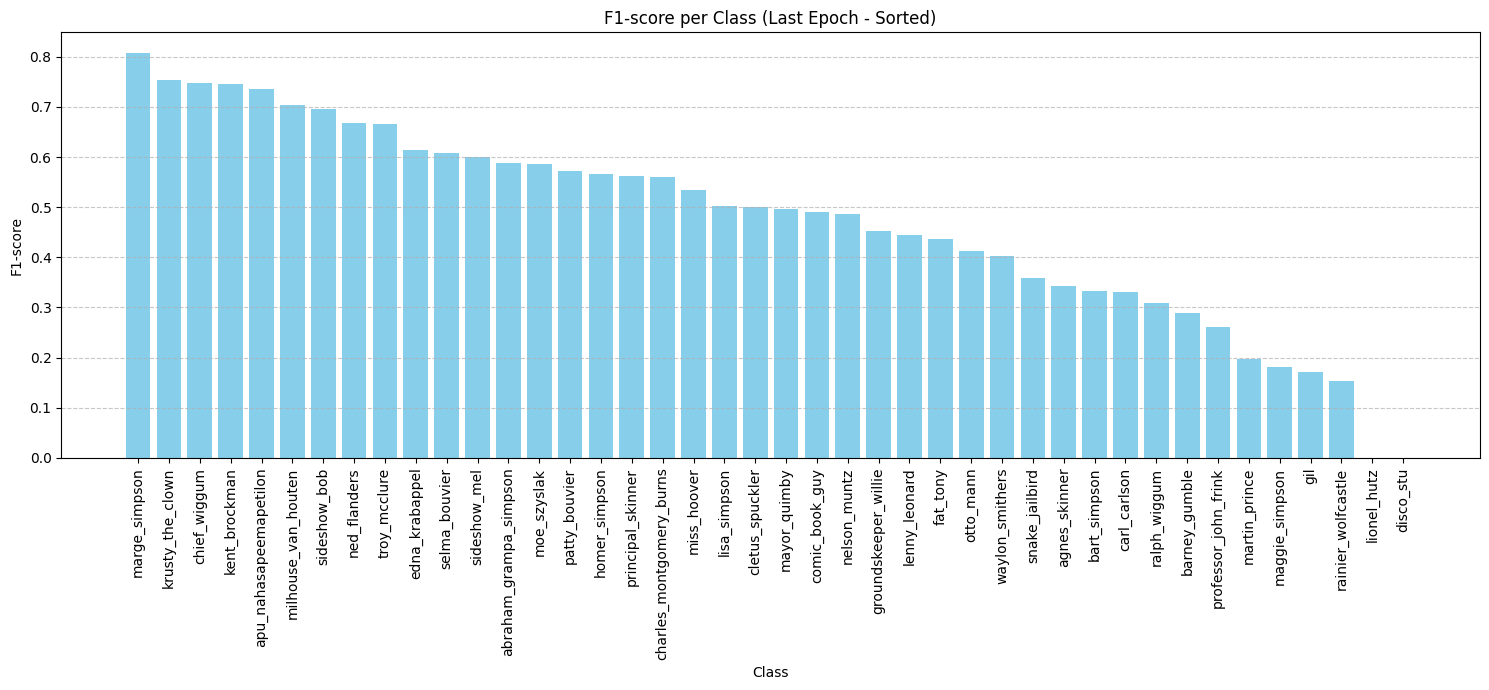

In [ ]:
# Пример запуска обучения с новым DataLoader
model_simple_cnn = SimpleCnn(n_classes = len(np.unique(train_val_labels)))
model_simple_cnn.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_simple_cnn.parameters(), lr = 1e-4) # Обновляем lr здесь тоже

history_balanced = train_func(
    model = model_simple_cnn,
    num_epochs = 15, # Увеличиваем количество эпох
    dataloaders = loaders_balanced, # Используем новый, сбалансированный лоадер
    optimizer = optimizer,
    loss_func = criterion,
    label_encoder = label_encoder
)

plot_history(history_balanced, label_encoder)

## Шаг 8. Работа с архитектурой сети

### AlexNet

Давайте базово пройдемся по сделанному в ноутбуке 07_2, для начала базовый AlexNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
from tqdm.notebook import tqdm

In [ ]:
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 149MB/s]


In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
# 2) Меняем последний классификатор на нужное количество классов
num_features = model.classifier[6].in_features  # обычно 4096
model.classifier[6] = nn.Linear(num_features, len(np.unique(train_val_labels)))

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
history = train_func(model = model,
                     num_epochs = 10,
                     dataloaders = loaders,
                     optimizer = optimizer,
                     loss_func = criterion,
                     label_encoder = label_encoder)



Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.3518 | f1: 0.6402


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.5582 | f1: 0.8496

Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.5582 | f1: 0.8464


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.4122 | f1: 0.8869

Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.3821 | f1: 0.8941


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.3498 | f1: 0.9029

Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.2947 | f1: 0.9181


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.3076 | f1: 0.9178

Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.2352 | f1: 0.9327


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.2729 | f1: 0.9266

Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1967 | f1: 0.9440


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.2590 | f1: 0.9348

Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1694 | f1: 0.9526


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.2694 | f1: 0.9305

Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1314 | f1: 0.9599


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.2628 | f1: 0.9360

Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1231 | f1: 0.9629


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.2840 | f1: 0.9316

Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1111 | f1: 0.9663


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.2698 | f1: 0.9371


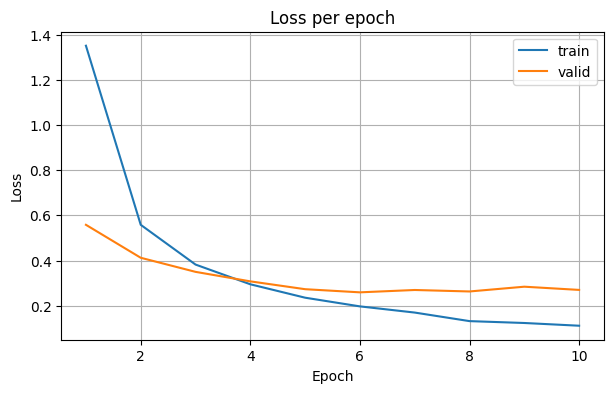

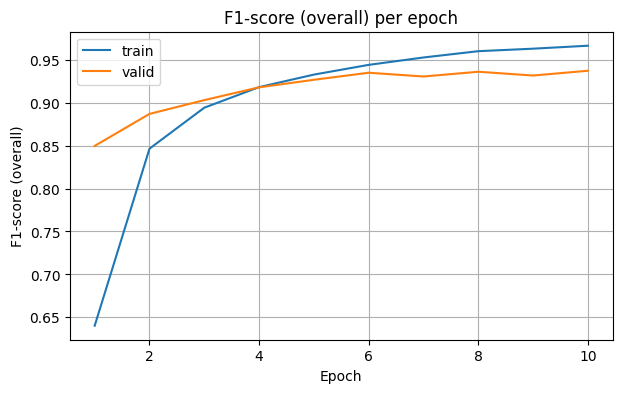

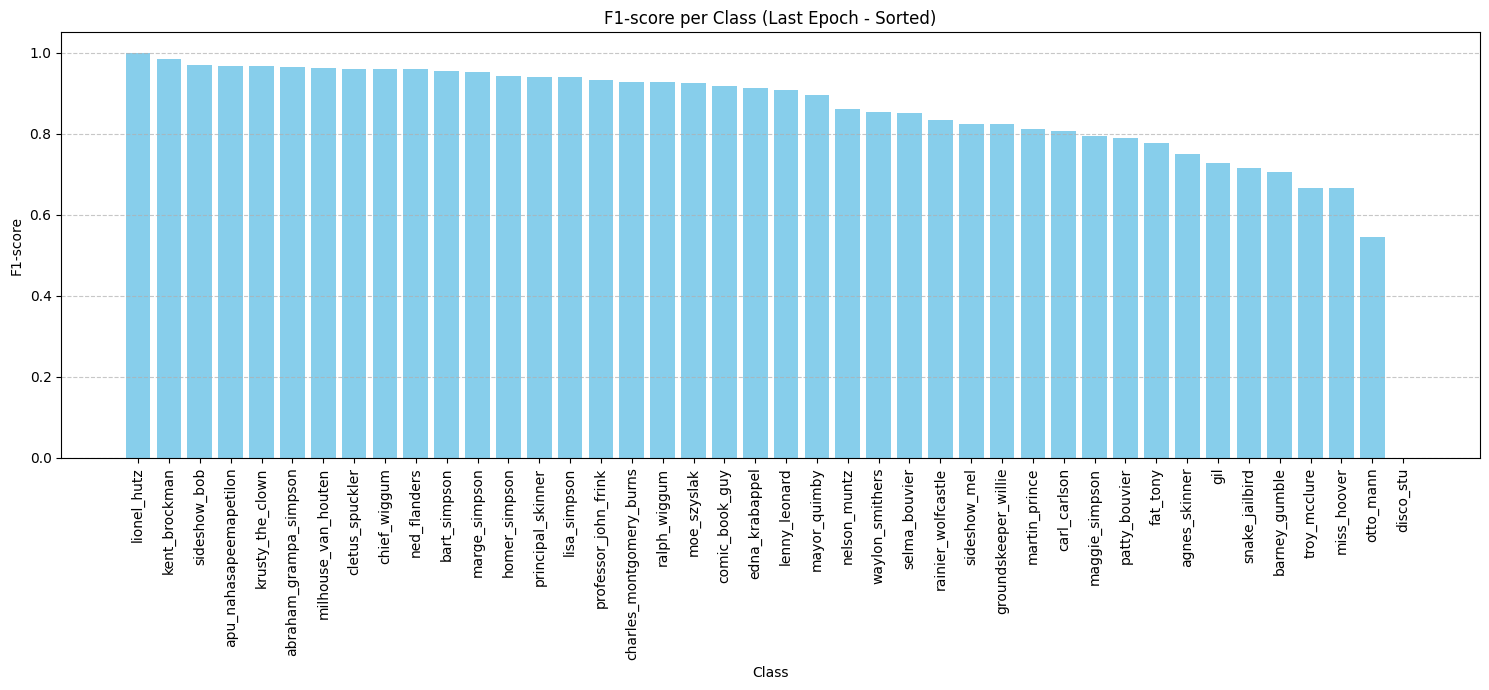

In [ ]:
plot_history(history, label_encoder)

Это довольно хороший результат, F1-score близок к 1 и на train и на valid

Итого мы получили:

Train | loss: 0.1111 | f1: 0.9663

Valid | loss: 0.2698 | f1: 0.9371


In [ ]:
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for saving
save_path_model = '/content/drive/MyDrive/Colab Notebooks/блок 7/alexnet_base.pth'
save_path_history = '/content/drive/MyDrive/Colab Notebooks/блок 7/training_history_alexnet_base.pkl'

# Save the model
torch.save(model.state_dict(), save_path_model)
print(f"Model saved to {save_path_model}")

# Save the history
with open(save_path_history, 'wb') as f:
    pickle.dump(history, f)
print(f"Training history saved to {save_path_history}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/Colab Notebooks/блок 7/alexnet_base.pth
Training history saved to /content/drive/MyDrive/Colab Notebooks/блок 7/training_history_alexnet_base.pkl


### 🚫AlexNet с полной заморозкой

In [ ]:
model_extractor = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)


In [ ]:
for param in model_extractor.parameters():
    print(param.requires_grad)  # нужно ли считать градиенты для этого параметра
    break

True


In [ ]:
# замораживаем параметры (веса)
for p in model_extractor.parameters():
    p.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 4096
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier[6] = nn.Linear(num_features, len(np.unique(train_val_labels)))
model_extractor = model_extractor.to(DEVICE)

# Обучаем только классификатор

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_extractor.classifier[6].parameters(), lr=1e-4)

In [ ]:
history_freeze = train_func(model_extractor,
                            10,
                            loaders,
                            optimizer,
                            criterion,
                            label_encoder)




Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 2.6192 | f1: 0.2842


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 2.0734 | f1: 0.4734

Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 2.0237 | f1: 0.4558


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.7647 | f1: 0.5483

Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.8230 | f1: 0.4984


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.6075 | f1: 0.5898

Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.7098 | f1: 0.5270


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.5079 | f1: 0.6110

Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.6201 | f1: 0.5490


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.4387 | f1: 0.6251

Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.5523 | f1: 0.5673


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.3921 | f1: 0.6305

Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.5162 | f1: 0.5728


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.3409 | f1: 0.6448

Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.4651 | f1: 0.5846


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.3109 | f1: 0.6513

Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.4386 | f1: 0.5909


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.2768 | f1: 0.6605

Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.4260 | f1: 0.5918


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.2493 | f1: 0.6687


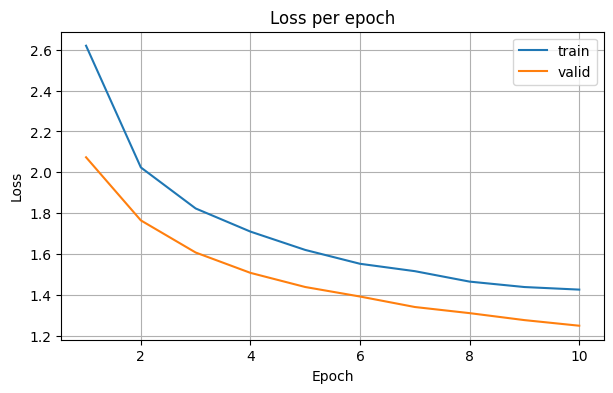

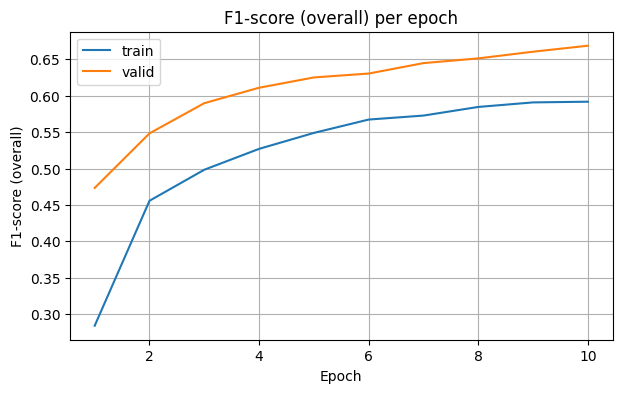

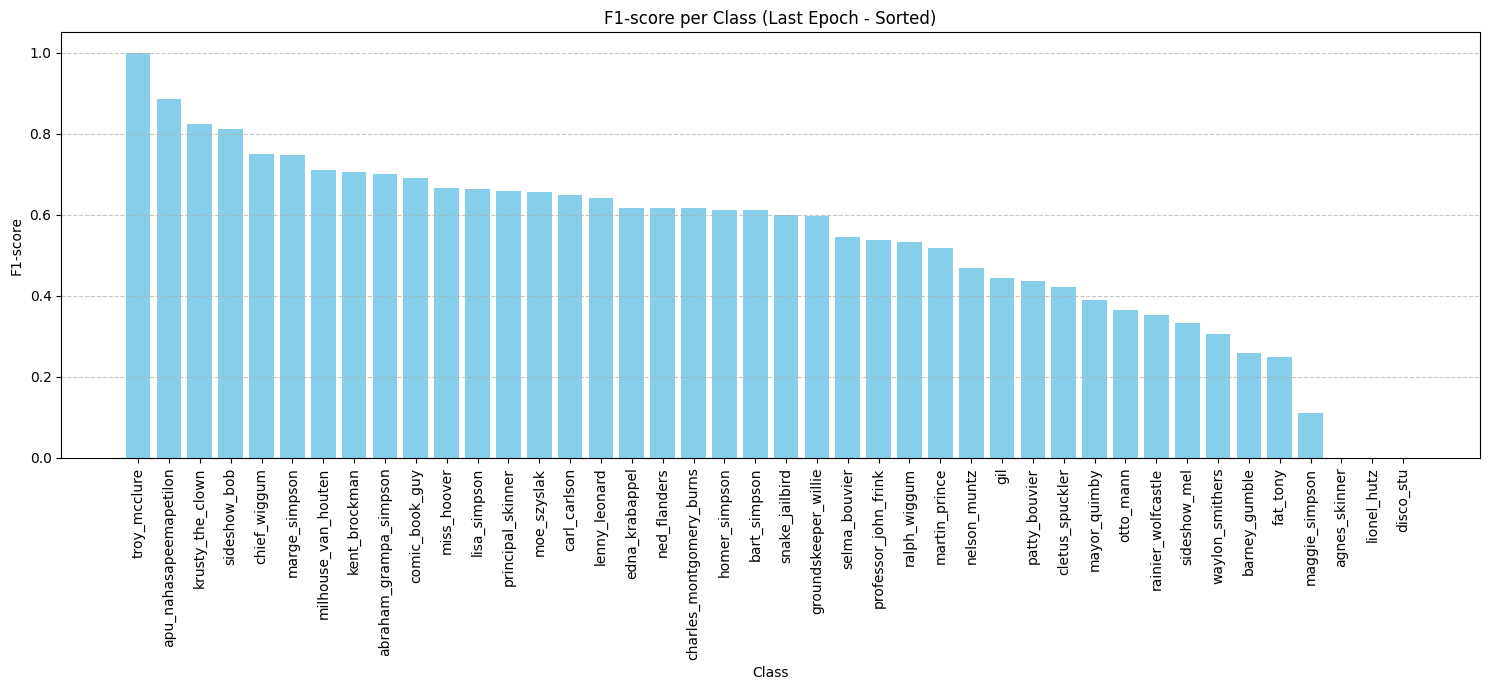

In [ ]:
plot_history(history_freeze, label_encoder)

Видим плохое качество, в целом это нормальная ситуация для полной заморозки, но попробовать стоило

Train | loss: 1.4260 | f1: 0.5918

Valid | loss: 1.2493 | f1: 0.6687


### AlexNet смешанные замороженные слои

In [ ]:
model_mixed = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)


In [ ]:
model_mixed

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
layers_to_unfreeze = 5

# 1) Замораживаем всё
for p in model_mixed.parameters():
    p.requires_grad = False

# 2) Размораживаем последние layers_to_unfreeze модулей в сверточной части
# (features у AlexNet — это nn.Sequential)
for block in model_mixed.features[-layers_to_unfreeze:]:
    for p in block.parameters():
        p.requires_grad = True

# 3) Меняем последний FC под 2 класса и размораживаем classifier целиком
num_features = model_mixed.classifier[6].in_features  # обычно 4096
model_mixed.classifier[6] = nn.Linear(num_features, len(np.unique(train_val_labels)))

for p in model_mixed.classifier.parameters():
    p.requires_grad = True

# 4) Модель на device
model_mixed = model_mixed.to(DEVICE)

# 5) Оптимизатор: только параметры, которые реально обучаются
optimizer = torch.optim.Adam(
    (p for p in model_mixed.parameters() if p.requires_grad),
    lr=1e-4
)

loss_func = nn.CrossEntropyLoss()

In [ ]:
history_mixed = train_func(
    model=model_mixed,
    num_epochs=10,
    dataloaders=loaders,
    optimizer=optimizer,
    loss_func=loss_func,
    label_encoder=label_encoder
)





Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.4711 | f1: 0.6135


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.6703 | f1: 0.8198

Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.6385 | f1: 0.8184


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.4674 | f1: 0.8720

Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.4374 | f1: 0.8773


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.3958 | f1: 0.8878

Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.3367 | f1: 0.9023


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.3495 | f1: 0.9052

Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.2654 | f1: 0.9229


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.3316 | f1: 0.9113

Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.2142 | f1: 0.9383


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.3120 | f1: 0.9148

Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1681 | f1: 0.9482


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.3233 | f1: 0.9194

Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1442 | f1: 0.9560


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.2870 | f1: 0.9236

Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1225 | f1: 0.9635


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.2975 | f1: 0.9274

Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1068 | f1: 0.9685


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.2886 | f1: 0.9314


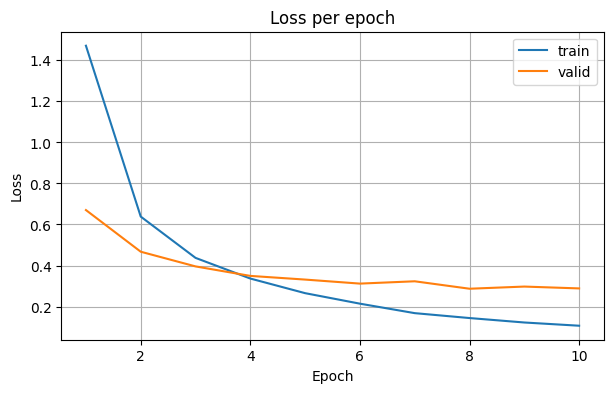

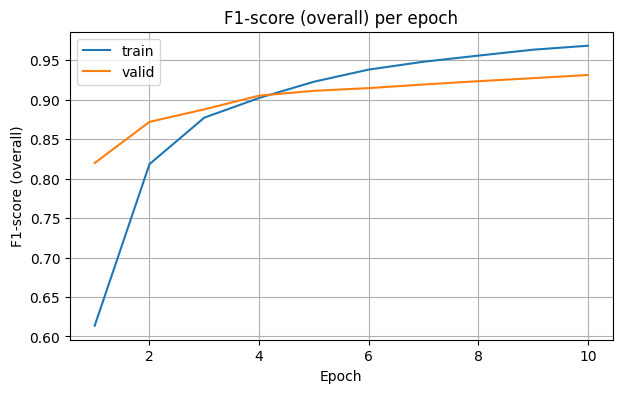

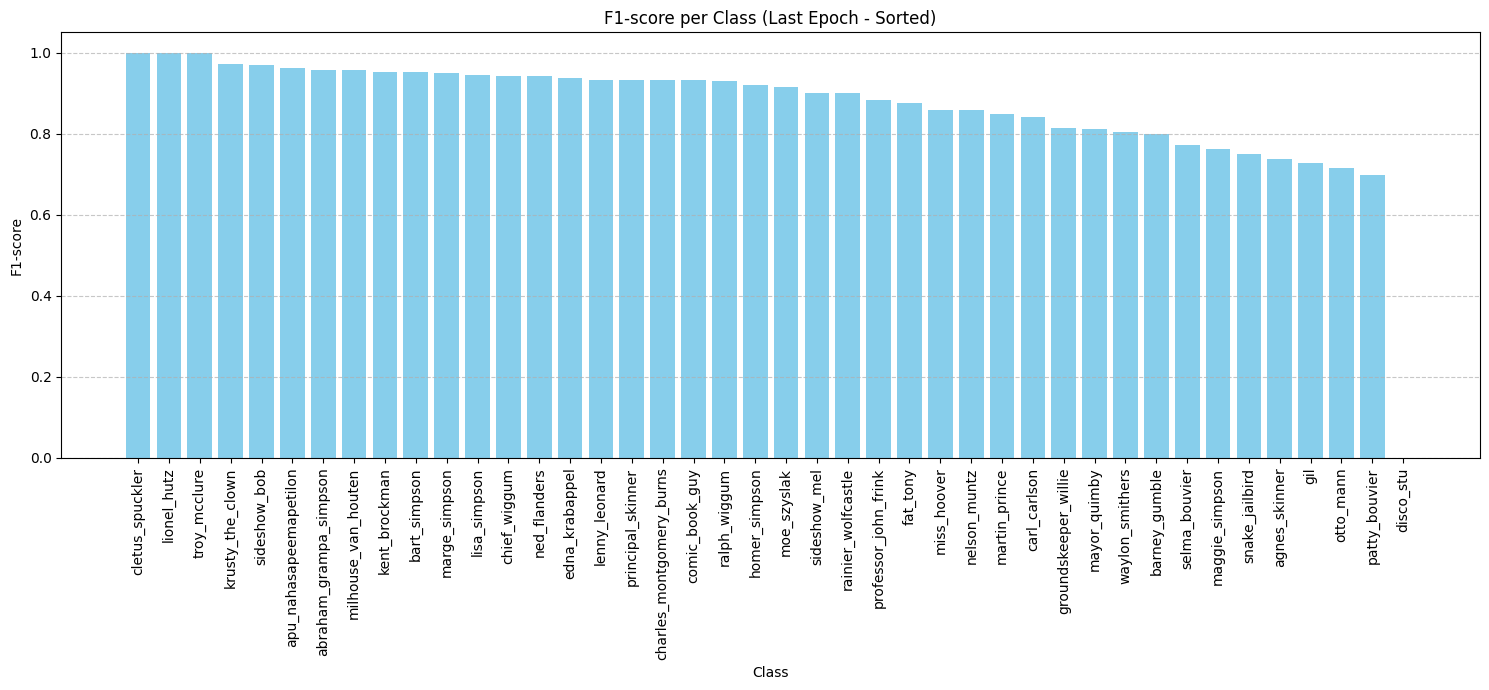

In [ ]:
plot_history(history_mixed, label_encoder)

AlexNet: Valid | loss: 0.2698 | f1: 0.9371

AlexNet со смешанными слоями: Valid | loss: 0.2886 | f1: 0.9314

Обычный AlexNet пока что лучше, но разница не сильная

In [ ]:
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for saving
save_path_model = '/content/drive/MyDrive/Colab Notebooks/блок 7/alexnet_freeze_mixed.pth'
save_path_history = '/content/drive/MyDrive/Colab Notebooks/блок 7/training_history_alexnet_freeze_mixed.pkl'

# Save the model
torch.save(model.state_dict(), save_path_model)
print(f"Model saved to {save_path_model}")

# Save the history
with open(save_path_history, 'wb') as f:
    pickle.dump(history, f)
print(f"Training history saved to {save_path_history}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/Colab Notebooks/блок 7/alexnet_freeze_mixed.pth
Training history saved to /content/drive/MyDrive/Colab Notebooks/блок 7/training_history_alexnet_freeze_mixed.pkl


### 🚫AlexNet. Работаем с lr

In [ ]:
model_mixed_lr = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 4096

# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed_lr.classifier[6] = nn.Linear(num_features, len(np.unique(train_val_labels)))

model_mixed_lr = model_mixed_lr.to(DEVICE)

In [ ]:
optimizer = torch.optim.Adam(
    [
        {"params": model_mixed_lr.features.parameters(), "lr": 1e-6},
        {"params": model_mixed_lr.classifier.parameters(), "lr": 1e-4},
    ]
)

loss_func = nn.CrossEntropyLoss()

In [ ]:
history_alexnet_mixed_lr = train_func(
    model=model_mixed_lr,
    num_epochs=10,
    dataloaders=loaders,
    optimizer=optimizer,
    loss_func=loss_func,
    label_encoder=label_encoder
)


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.8326 | f1: 0.5067


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.0058 | f1: 0.7293

Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.0590 | f1: 0.7056


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.7741 | f1: 0.7875

Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.8171 | f1: 0.7655


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.6482 | f1: 0.8191

Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.6559 | f1: 0.8120


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.5820 | f1: 0.8357

Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.5432 | f1: 0.8408


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.5275 | f1: 0.8529

Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.4622 | f1: 0.8641


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.4585 | f1: 0.8708

Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.3939 | f1: 0.8819


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.4719 | f1: 0.8712

Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.3450 | f1: 0.8948


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.4438 | f1: 0.8802

Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.3025 | f1: 0.9072


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.4352 | f1: 0.8836

Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.2662 | f1: 0.9181


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.4428 | f1: 0.8842


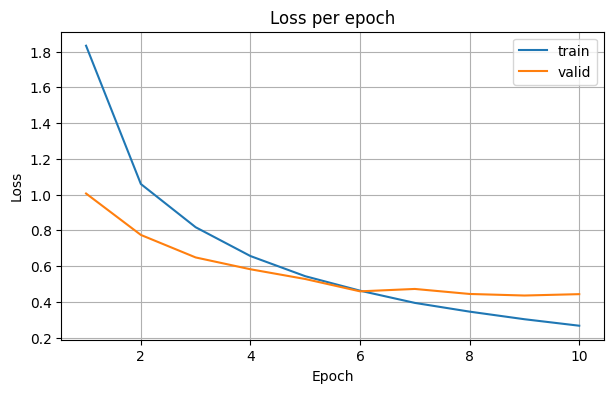

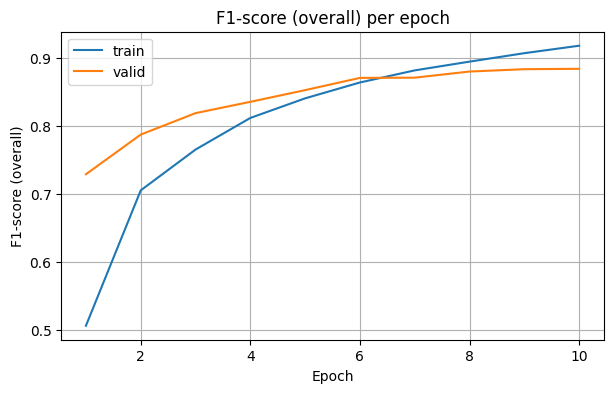

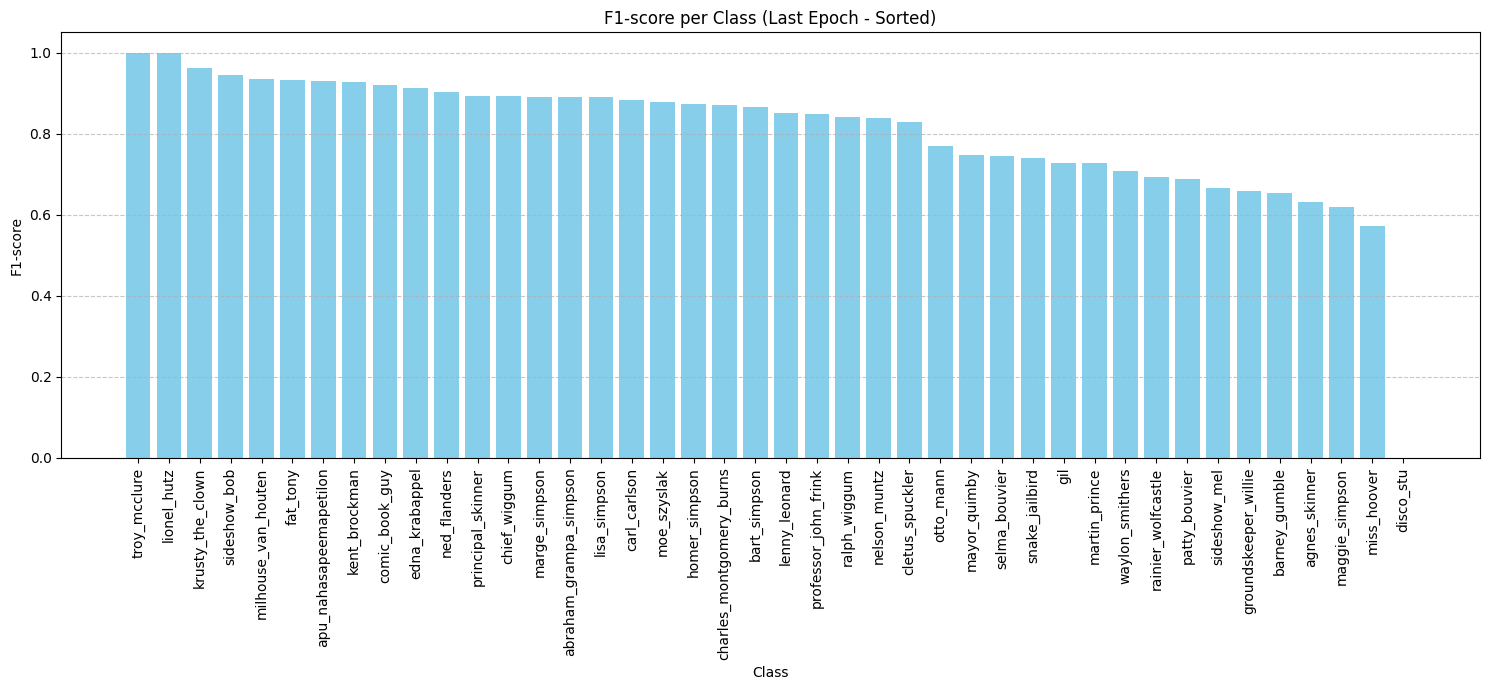

In [ ]:
plot_history(history_alexnet_mixed_lr, label_encoder)

Стало хуже:
Valid | loss: 0.4428 | f1: 0.8842

### ResNet

In [ ]:
model_extractor = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


In [ ]:
model_extractor

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 1) замораживаем параметры (веса)
for p in model_extractor.parameters():
    p.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512

# 2) Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc = nn.Linear(num_features, len(np.unique(train_val_labels)))

# новый слой обучаем
for p in model_extractor.fc.parameters():
    p.requires_grad = True

model_extractor = model_extractor.to(DEVICE)
loss_func = nn.CrossEntropyLoss()
# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.fc.parameters(), lr=1e-3)

In [ ]:
history_resnet_step1= train_func(
    model=model_extractor,
    num_epochs=10,
    dataloaders=loaders,
    optimizer=optimizer,
    loss_func=loss_func,
    label_encoder=label_encoder
)


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 2.3463 | f1: 0.4126


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.7778 | f1: 0.5755

Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.5835 | f1: 0.6084


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.4310 | f1: 0.6448

Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.3350 | f1: 0.6526


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.3193 | f1: 0.6590

Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.2151 | f1: 0.6842


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.2604 | f1: 0.6658

Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.1440 | f1: 0.6931


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.1813 | f1: 0.6876

Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.0803 | f1: 0.7064


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.1722 | f1: 0.6800

Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.0562 | f1: 0.7078


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.1306 | f1: 0.6989

Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.0217 | f1: 0.7165


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.1345 | f1: 0.6979

Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 1.0072 | f1: 0.7180


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.1115 | f1: 0.6964

Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.9722 | f1: 0.7306


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 1.0783 | f1: 0.7039


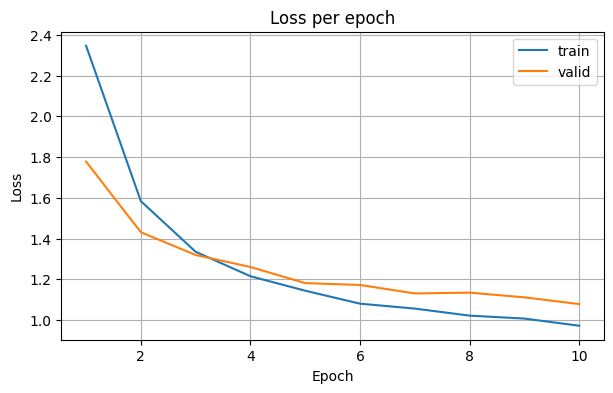

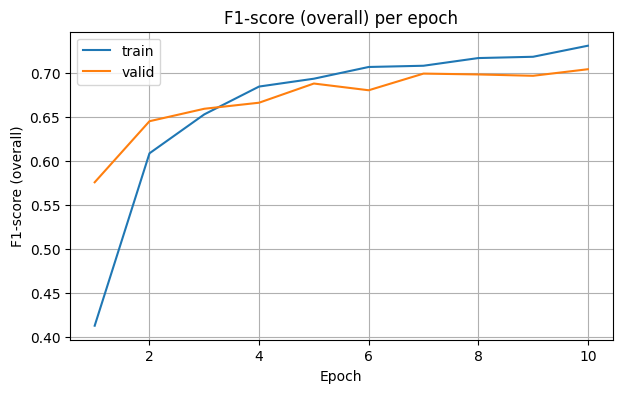

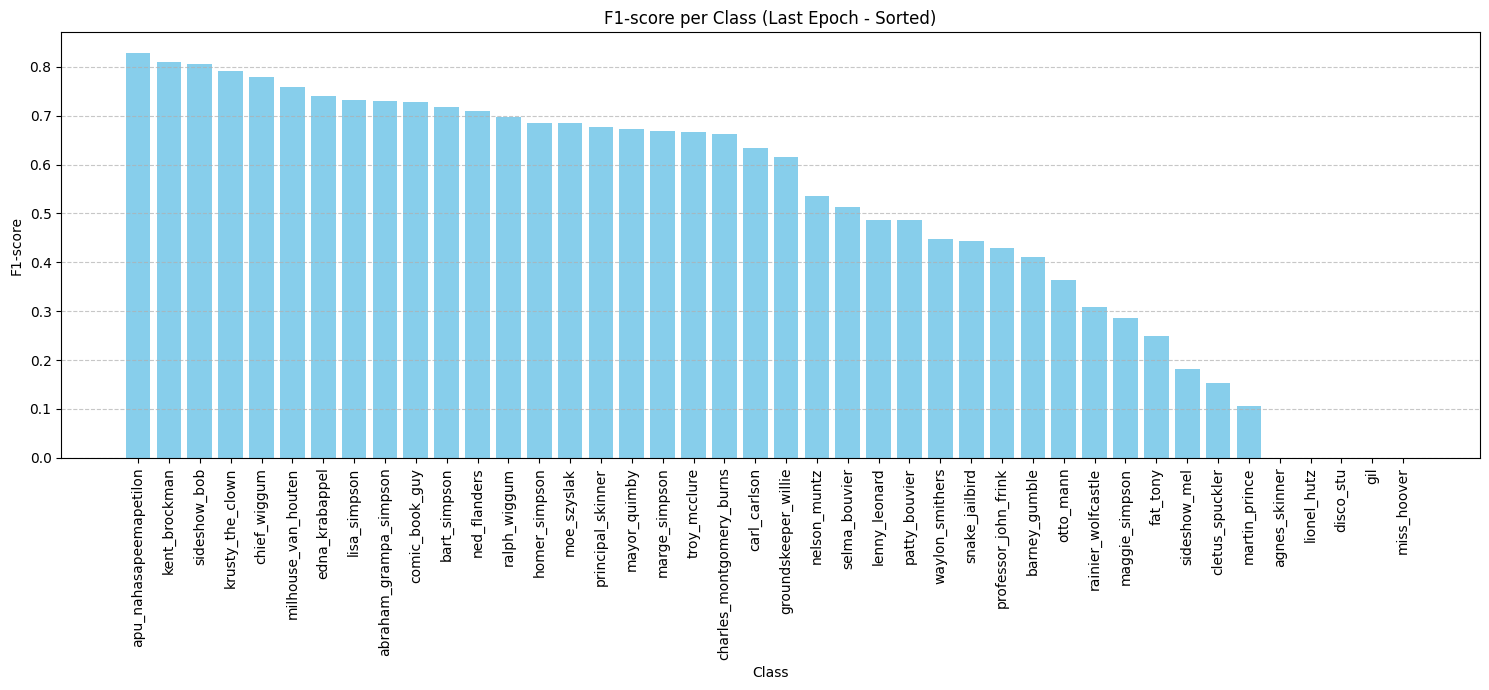

In [ ]:
plot_history(history_resnet_step1, label_encoder)

In [ ]:
# размораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_extractor.parameters(), lr=1e-4)

In [ ]:
history_resnet_step2 = train_func(
    model=model_extractor,
    num_epochs=10,
    dataloaders=loaders,
    optimizer=optimizer,
    loss_func=loss_func,
    label_encoder = label_encoder
)


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.3798 | f1: 0.8971


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.2531 | f1: 0.9306

Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.1449 | f1: 0.9625


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1851 | f1: 0.9505

Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0859 | f1: 0.9774


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1764 | f1: 0.9555

Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0614 | f1: 0.9849


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1855 | f1: 0.9540

Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0373 | f1: 0.9908


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1700 | f1: 0.9557

Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0349 | f1: 0.9906


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1743 | f1: 0.9593

Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0272 | f1: 0.9918


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1588 | f1: 0.9622

Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0246 | f1: 0.9938


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1585 | f1: 0.9669

Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0317 | f1: 0.9910


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1850 | f1: 0.9574

Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0214 | f1: 0.9945


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1544 | f1: 0.9658


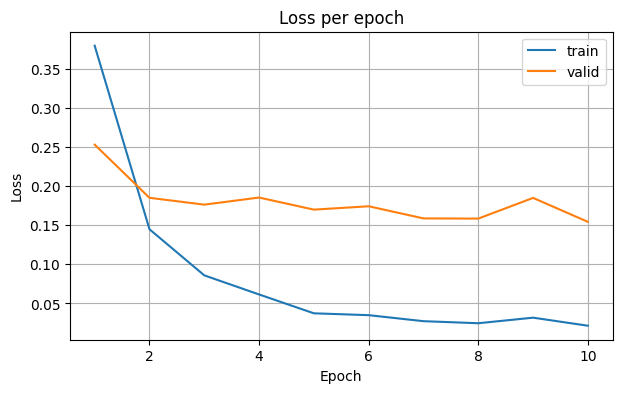

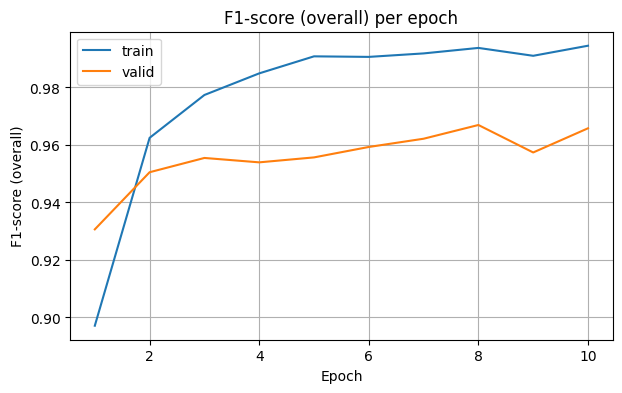

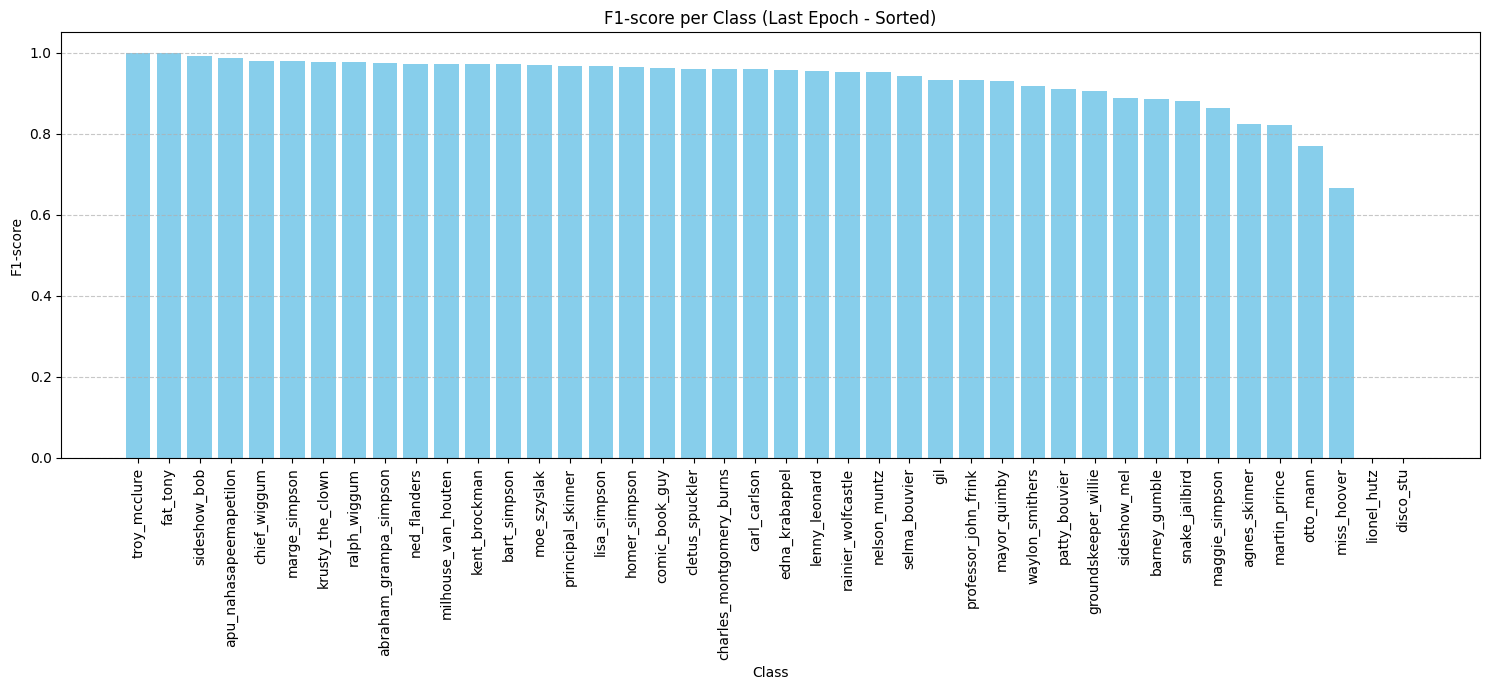

In [ ]:
plot_history(history_resnet_step2, label_encoder)

In [ ]:
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for saving
save_path_model = '/content/drive/MyDrive/Colab Notebooks/блок 7/resnet_freeze.pth'
save_path_history = '/content/drive/MyDrive/Colab Notebooks/блок 7/training_history_resnet_freeze.pkl'

# Save the model
torch.save(model_extractor.state_dict(), save_path_model)
print(f"Model saved to {save_path_model}")

# Save the history
with open(save_path_history, 'wb') as f:
    pickle.dump(history_resnet_step2, f)
print(f"Training history saved to {save_path_history}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/Colab Notebooks/блок 7/resnet_freeze.pth
Training history saved to /content/drive/MyDrive/Colab Notebooks/блок 7/training_history_resnet_freeze.pkl


Давайте еще добавим разный lr и изменим 2 шаг модели, а также добавим weight_decay

In [ ]:
backbone_params = [p for n,p in model.named_parameters() if not n.startswith("fc.")]
head_params = [p for n,p in model.named_parameters() if n.startswith("fc.")]
optimizer = optim.AdamW([
    {"params": backbone_params, "lr": 1e-4},
    {"params": head_params, "lr": 1e-3}
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
def train_func(model, num_epochs, dataloaders, optimizer, loss_func, label_encoder, patience=5, scheduler=None):
  '''
  args:
    model - модель для обучения
    num_epochs - количество эпох
    dataloaders - словарь loader'ов с обучающей и валидационной выборками
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`
    label_encoder - кодировщик меток для преобразования числовых меток в текстовые
    scheduler - планировщик скорости обучения (опционально)

  функция возвращает accuracy на обучающей и валидационной выборках на каждой эпохе
  '''

  history = {
      "train_loss": [], "valid_loss": [],
      "train_f1": [], "valid_f1": [],
      "train_f1_per_class": [],
      "valid_f1_per_class": []
  }

  best_f1_valid = -1.0
  epochs_no_improve = 0
  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}")

    loss_train, train_preds, train_labels = fit_one_epoch(
        model=model,
        train_dataloader=dataloaders['train'],
        optimizer=optimizer,
        loss_func=loss_func
    )
    f1_train = f1_score(train_labels, train_preds, average='micro')
    f1_train_per_class = f1_score(train_labels, train_preds, average=None, labels=np.arange(len(label_encoder.classes_)))

    print(f"Train | loss: {loss_train:.4f} | f1: {f1_train:.4f}")

    loss_valid, valid_preds, valid_labels = eval_one_epoch(
        model=model,
        val_dataloader=dataloaders['val'],
        loss_func=loss_func
    )
    f1_valid = f1_score(valid_labels, valid_preds, average='micro')
    f1_valid_per_class = f1_score(valid_labels, valid_preds, average=None, labels=np.arange(len(label_encoder.classes_)))

    print(f"Valid | loss: {loss_valid:.4f} | f1: {f1_valid:.4f}")

    history["train_loss"].append(loss_train)
    history["valid_loss"].append(loss_valid)
    history["train_f1"].append(f1_train)
    history["valid_f1"].append(f1_valid)
    history["train_f1_per_class"].append(f1_train_per_class)
    history["valid_f1_per_class"].append(f1_valid_per_class)

    # Update scheduler
    if scheduler is not None:
        scheduler.step()
        print(f"\tLR: {optimizer.param_groups[0]['lr']:.6f}")


  return history

In [ ]:
history_resnet_step2 = train_func(
    model=model_extractor,
    num_epochs=15,
    dataloaders=loaders,
    optimizer=optimizer,
    loss_func=loss_func,
    label_encoder = label_encoder,
    scheduler = scheduler
)


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0180 | f1: 0.9950


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1523 | f1: 0.9668
	LR: 0.000002

Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0174 | f1: 0.9960


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1522 | f1: 0.9662
	LR: 0.000000

Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0197 | f1: 0.9949


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1511 | f1: 0.9668
	LR: 0.000002

Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0173 | f1: 0.9956


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1522 | f1: 0.9664
	LR: 0.000010

Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0185 | f1: 0.9957


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1532 | f1: 0.9664
	LR: 0.000021

Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0189 | f1: 0.9946


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1523 | f1: 0.9658
	LR: 0.000035

Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0165 | f1: 0.9957


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1522 | f1: 0.9660
	LR: 0.000050

Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0176 | f1: 0.9957


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1532 | f1: 0.9671
	LR: 0.000065

Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0177 | f1: 0.9946


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1530 | f1: 0.9668
	LR: 0.000079

Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0186 | f1: 0.9950


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1502 | f1: 0.9675
	LR: 0.000090

Epoch: 11


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0187 | f1: 0.9950


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1516 | f1: 0.9668
	LR: 0.000098

Epoch: 12


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0170 | f1: 0.9962


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1541 | f1: 0.9647
	LR: 0.000100

Epoch: 13


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0161 | f1: 0.9964


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1553 | f1: 0.9660
	LR: 0.000098

Epoch: 14


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0171 | f1: 0.9957


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1516 | f1: 0.9669
	LR: 0.000090

Epoch: 15


  0%|          | 0/246 [00:00<?, ?it/s]

Train | loss: 0.0192 | f1: 0.9950


  0%|          | 0/82 [00:00<?, ?it/s]

Valid | loss: 0.1513 | f1: 0.9666
	LR: 0.000079


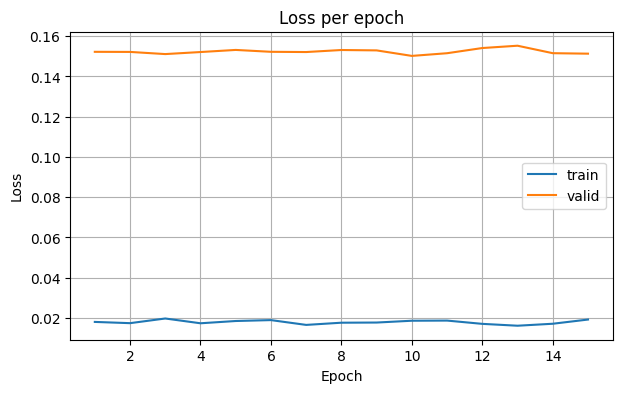

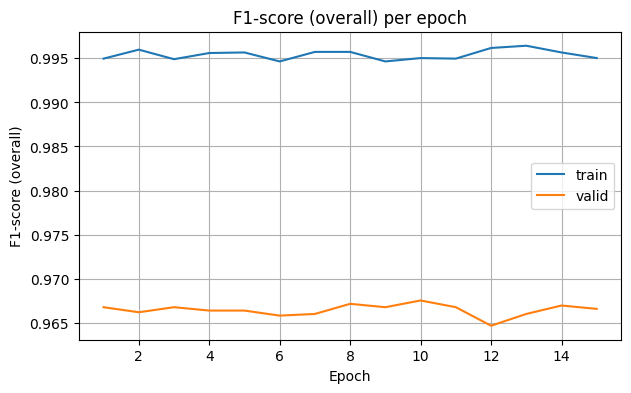

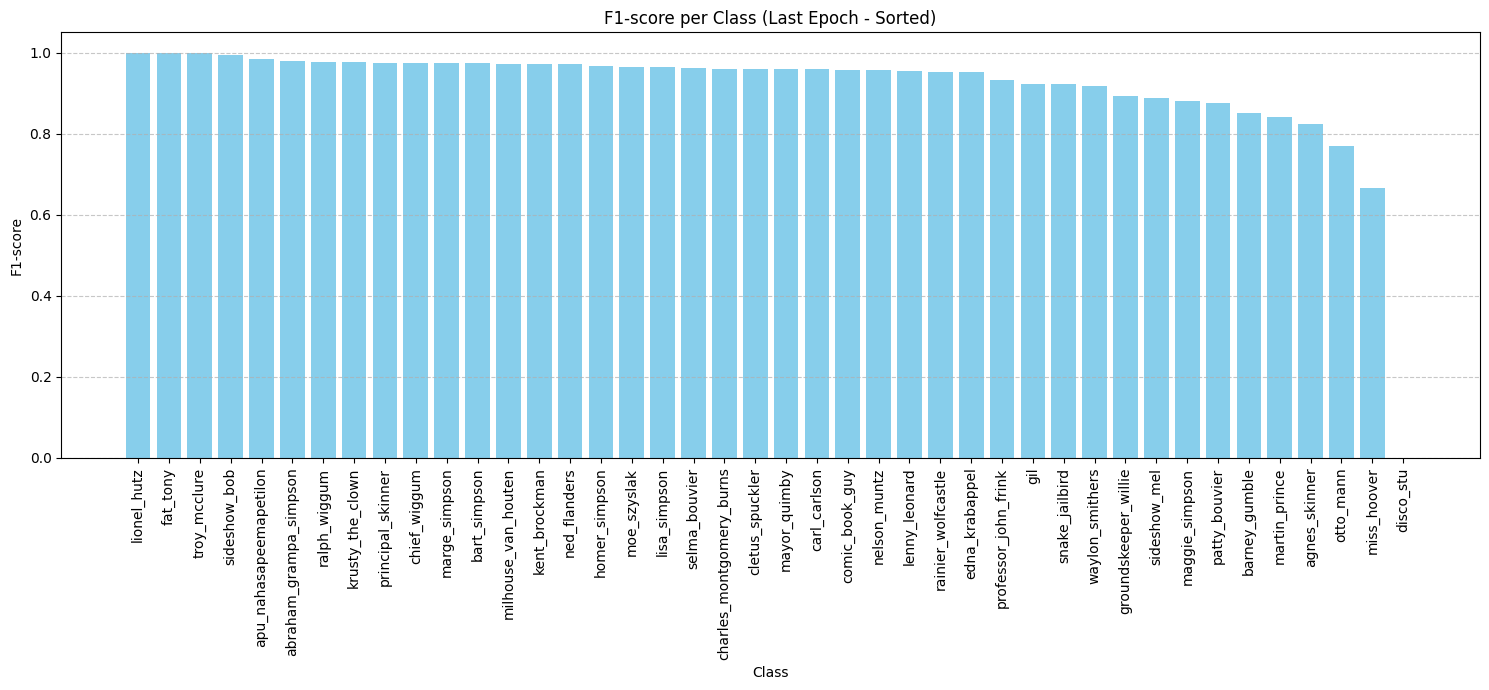

In [ ]:
plot_history(history_resnet_step2, label_encoder)

In [ ]:
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for saving
save_path_model = '/content/drive/MyDrive/Colab Notebooks/блок 7/resnet_lr.pth'
save_path_history = '/content/drive/MyDrive/Colab Notebooks/блок 7/training_history_resnet_lr.pkl'

# Save the model
torch.save(model_extractor.state_dict(), save_path_model)
print(f"Model saved to {save_path_model}")

# Save the history
with open(save_path_history, 'wb') as f:
    pickle.dump(history_resnet_step2, f)
print(f"Training history saved to {save_path_history}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/Colab Notebooks/блок 7/resnet_lr.pth
Training history saved to /content/drive/MyDrive/Colab Notebooks/блок 7/training_history_resnet_lr.pkl


Итоговый score на тестовом датасете в [kaggle](https://www.kaggle.com/competitions/journey-to-springfield1/overview) составил 0.98831